In [1]:
!pip install tslearn
!pip install torchvision
!pip install pesq
!pip install pystoi

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [1]:
! pip install --upgrade torchvision==0.20.0


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 24.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1
    Uninstalling torchvision-0.20.1:
      Successfully uninstalled torchvision-0.20.1

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [2]:
import IPython
import os
from scipy.io import wavfile
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
from pesq import pesq
from pystoi.stoi import stoi
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import pickle
from torch.utils.data import random_split
import torch.nn.functional as F
import os
import torchaudio.transforms as T

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# MVA 2024 : Cours Deep et signal, mini-projet
## Sujet : Complétion de Paquets Perdus

Consignes :

Pour chaque sujet vous êtes invités à prendre des initiatives notamment pour
- analyser les données (statistiques haut niveau, visualisation, évaluation des difficultés)
- partir du cours ou d'un article lié au sujet traité que vous aurez identifié dans une (rapide) étude bibliographique
- définir une ou plusieurs métriques d'évaluation
- définir et implémenter une méthode baseline dont les performances vous serviront de référence
- implémenter au moins une et idéalement deux méthodes traitant le problème considéré. Au moins une des deux méthodes est une approche par apprentissage profond. La seconde peut être une approche de traitement du signal classique, une autre architecture de réseau, la même architecture avec une stratégie d'augmentation de données ou d’ingénierie des données...
- comparer les approches quantitativement et analyser qualitativement vos résultats, les cas de succès et les cas d'échecs.

Si vous n'avez pas abouti à des résultats probants sur cette durée vous êtes invités à analyser de façon critique vos résultats et émettre des hypothèse sur ce qui n'a pas fonctionné (type d'approche, architecture, qualité des données...).
Une bonne analyse de vos résultats et une méthodologie rigoureuses seront largement valorisées dans l'évaluation, vos initiatives aussi.

Pour l'évaluation je serai très attentif à la méthodologie que vous avez suivie, aux initiatives que vous aurez prises et à l'analyse critique des données, du sujet, des approches, de vos résultats..

Pour chaque sujet, vous êtes libres d'explorer les pistes qui vous intéressent (tant qu'elles sont raisonnables).
Si vous avez des idées originales n'hésitez pas à être créatifs !


### Complétion de paquets perdus
Lors d'une communication sur IP les échantillons sont envoyés sous forme de paquets. Un paquet a une certaine probabilité d'être perdu ce qui produit un "trou" dans le signal reçu.
L'objectif de ce projet est de combler les trous dans un signal de voix.

Le dataset de train se compose de  :
- Un dossier contenant des fichiers d'enregistrements de voix à 8kHz  (audio/voice_origin/train) ; ce sont les données objectifs
- Un dossier contenant les fichiers correspondants avec certains paquets qui ont été perdu (audio/packet_loss/train) ; ce sont les données d'entrée à traiter

La correspondance entre les deux dossiers pour reconstituer les paires (donnée d'entrée, vérité terrain) se fait par le nom de fichier.
Les données de test sont structurées de la même façon.

Vous pouvez au choix travailler sur spectrogramme ou directement sur la forme d'onde en vous inspirant par exemple des références données pour la séparation de sources (UNet, WavUnet)

- Sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours  et en estimant les masques avec un réseau Seq2Seq de votre choix ou un UNet (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  : cf D. Stoller  et Al., WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018

Pour ce sujet vous implémenterez nécessairement une approche classique  par exemple en utilisant des interpolations et une méthode à base de réseaux de neurones profonds.

Libre à vous de choisir la fonction de perte utilisée dans l’entraînement.
Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.

# Chargement des données

In [31]:
# Charger le drive
#from google.colab import drive
#drive.mount('/content/drive')
# Chemin du répertoire de mon drive contenant les données
#chemin = '/content/drive/MyDrive/Colab Notebooks/S1 I&I/mini-projet/'
chemin = "."

In [32]:
# Fonction pour charger les données
def charger_donnees(dossier):
    list_to_fill = []
    # Parcourir les fichiers .wav dans le dossier
    for fichier in os.listdir(dossier):
        if fichier.endswith(".wav"):
            chemin_complet = os.path.join(dossier, fichier)
            samplerate, data = wavfile.read(chemin_complet)
            list_to_fill.append({
                "nom": fichier,
                "samplerate": samplerate,
                "data": data})
    return sorted(list_to_fill, key=lambda d: d["nom"]) # on trie dans l'ordre alphabétique

In [33]:
dossier_packetloss_train, dossier_voiceorigin_train = chemin + '/packet_loss/train', chemin + '/voice_origin/train'
dossier_packetloss_test, dossier_voiceorigin_test = chemin + '/packet_loss/test', chemin + '/voice_origin/test'

X_train, Y_train = charger_donnees(dossier_packetloss_train), charger_donnees(dossier_voiceorigin_train)
X_test, Y_test = charger_donnees(dossier_packetloss_test), charger_donnees(dossier_voiceorigin_test)

print(f"Ensemble d'entraînement : {len(X_train)} fichiers avec pertes de paquets et {len(Y_train)} fichiers de voix originaux.")
print(f"Ensemble de test : {len(X_test)} fichiers avec pertes de paquets et {len(Y_test)} fichiers de voix originaux.")

Ensemble d'entraînement : 2118 fichiers avec pertes de paquets et 2118 fichiers de voix originaux.
Ensemble de test : 782 fichiers avec pertes de paquets et 782 fichiers de voix originaux.


In [34]:
# On vérifie qu'il y a bien une unique sample rate (à enlever ?)
samplerates = []
for dic in X_train : samplerates.append(dic['samplerate'])
for dic in Y_train : samplerates.append(dic['samplerate'])
for dic in X_test : samplerates.append(dic['samplerate'])
for dic in Y_test : samplerates.append(dic['samplerate'])
print("La liste des differentes samplerates du dataset de train et test est :", np.unique(np.array(samplerates)))
samplerate = samplerates[0]

La liste des differentes samplerates du dataset de train et test est : [8000]


## Ecoutons un signal avec et sans perte de paquets

In [35]:
idx = np.random.randint(0, len(X_train))
print("Signal choisi : ", idx)

Signal choisi :  1296


In [36]:
print(Y_train[idx]['nom'],'\n')
IPython.display.Audio(Y_train[idx]['data'], rate=samplerate) #without (original sound)

Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap13_80_.wav 



In [37]:
print(X_train[idx]['nom'],'\n')
IPython.display.Audio(X_train[idx]['data'], rate=samplerate) #with packet loss

Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap13_80_.wav 



## Traçons-le

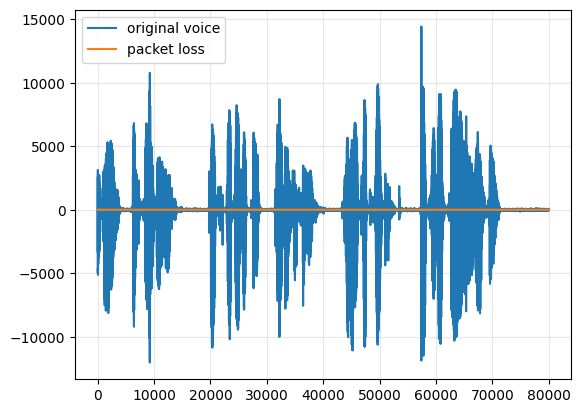

In [38]:
idx = 145
plt.figure()
plt.plot(Y_train[idx]['data'], label ="original voice")
plt.plot(X_train[idx]['data'], label = "packet loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

On ne voit pas le signal avec la perte de paquets : **il faut re-normaliser les signaux**

In [39]:
# Fonction pour normaliser un signal
def normaliser(signal):
    max_val = np.max(np.abs(signal))
    return signal / max_val

# On normalise les signaux
for dic in X_train : dic['data'] = normaliser(dic['data'])
for dic in Y_train : dic['data'] = normaliser(dic['data'])
for dic in X_test : dic['data'] = normaliser(dic['data'])
for dic in Y_test : dic['data'] = normaliser(dic['data'])

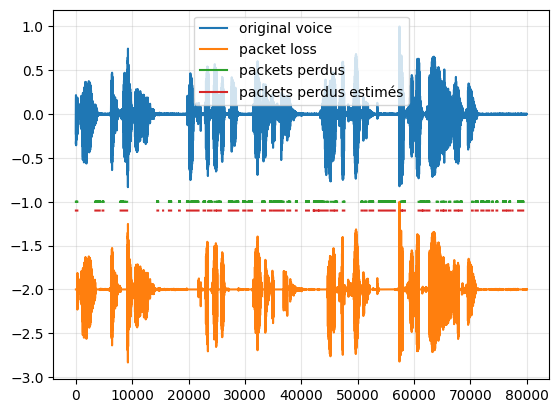

In [40]:
# Signal analysis
idx = 145
signal_og = Y_train[idx]['data']
signal_loss = X_train[idx]['data']
# On cherche les vrais paquets perdus
bursts = np.nan * np.ones(len(signal_og))
indices_paquets_perdus = np.where(np.abs(signal_og - signal_loss) > 1e-3)
bursts[indices_paquets_perdus] = -1
# On estime les paquets perdus
bursts_estimes = np.nan * np.ones(len(signal_loss))
indices_paquets_perdus_estimes = np.where(signal_loss == 0.0)
bursts_estimes[indices_paquets_perdus_estimes] = -1.1
# Plot
plt.figure()
plt.plot(signal_og, label ="original voice")
plt.plot(signal_loss-2, label = "packet loss")
plt.plot(bursts, label = "packets perdus")
plt.plot(bursts_estimes, label = "packets perdus estimés")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [41]:
IPython.display.Audio(signal_og, rate=samplerate)

In [42]:
IPython.display.Audio(signal_loss, rate=samplerate)

## Analyse exploratoire du dataset de train pour quantifier la dégradation des signaux

On cherche à quantifier à quel point chaque signal est dégradé. Nous avons utilisé plusieurs quantités pour évaluer la dégradation:


- Pourcentage de la durée du signal qui est perdue
- Nombre de paquets perdus (un paquet = burst contigu de pertes)
- Durée moyenne d'un paquet perdu
- MSE (Mean Square Error) entre le signal original et le signal dégradé
- PESQ (Perceptual Evaluation of Speech Quality):
  - PESQ $\in \left[1;2\right[$ impossible de comprendre
  - PESQ $\in \left[2;2.4\right[$ effort considérable pour comprendre
  - PESQ $\in \left[2.4;2.8\right[$ effort modéré pour comprendre
  - PESQ $\in \left[2.8;3.3\right[$ attention nécessaire et effort léger
  - PESQ ∈ $\in \left[3.3;3.8\right[$ attention nécessaire
  - PESQ $\in \left[3.8;4.5\right[$ aucun effort requis
- STOI (Short-Time Objective Intelligibility) :
  - STOI $\in \left[0;1\right]$ (1 pour reconstruction parfaite)


In [43]:
# Differentes métriques pour évaluer la distance signal dégradé - signal original
def MSE(x, x_reconstructed):
  assert(type(x) == type(x_reconstructed) == np.ndarray)
  assert(x.shape == x_reconstructed.shape)
  return np.sum((x - x_reconstructed)**2) / len(x) #c'est la même len que x_reconstructed et x-x_reconstructed

def SNR(x, x_reconstructed):
  assert(type(x) == type(x_reconstructed) == np.ndarray)
  assert(x.shape == x_reconstructed.shape)
  return 10 * np.log10(np.sum(x**2) / np.sum((x - x_reconstructed)**2))

# Differentes statistiques sur 1 signal
def liste_paquets_perdus_boolean(signal):
  paquets_perdus_estimes = False * np.ones(len(signal))
  indices_paquets_perdus = np.where(signal == 0.0)
  paquets_perdus_estimes[indices_paquets_perdus] = True
  return paquets_perdus_estimes

def true_blocks_dictionnary(lst):
  """
  retourne pour une liste de True/False
  (True : il y a un paquet perdu à cet indice dans le signal sonore)
  un dictionnaire ayant pour clés : l'indice de début du paquet perdu
  et pour valeur : la durée du paquet perdu
  """
  result = {}
  start = None  # Indice de début d'un bloc de True
  for i, val in enumerate(lst):
      if val:  # Si c'est un True
          if start is None:  # Début d'un nouveau bloc
              start = i
      else:  # Si c'est un False
          if start is not None:  # Fin d'un bloc de True
              result[start] = i - start  # Longueur du bloc
              start = None
  # Ajouter le dernier bloc s'il se termine par un True
  if start is not None:
      result[start] = len(lst) - start
  return result

def statistiques_sur_paquets_perdus(signal):
  paquets_perdus_estimes = liste_paquets_perdus_boolean(signal)
  paquets_perdus_dictionnary = true_blocks_dictionnary(paquets_perdus_estimes)
  # pourcentage perdu
  pourcentage_perdu = sum(paquets_perdus_estimes) / len(signal)
  # nb paquets contigus
  nb_paquets_contigus = len(paquets_perdus_dictionnary)
  # duree moyenne paquets perdu
  duree_moyenne_paquet = np.mean(list(paquets_perdus_dictionnary.values())) / samplerate
  return pourcentage_perdu*100, nb_paquets_contigus, duree_moyenne_paquet

In [61]:
def histogrammes(X, Y):
  # Calculs de statistiques sur le dataset avec les signaux avec paquets perdus
  pourcentages_perdus = []
  nb_paquets_contigus = []
  durees_moyenne_paquet = []
  # Calculs de comparaisons entre signaux avec et sans perte
  mse_scores = []
  pesq_scores = []
  stoi_scores = []
  for i in range(len(X)):
    if type(X)==dict:
      signal_avec_loss = X[i]['data']
    else :
      signal_avec_loss = X[i]
    signal_sans_loss = Y[i]['data']
    # Ecrire la progression dans la sortie
    sys.stdout.write(f"\rSignal n° {i + 1}/{len(X)}")
    sys.stdout.flush()
    # Remplissage des listes
    # Statistiques
    pourcentage_perdu, nb_paquet_contigue, duree_moyenne_paquet = statistiques_sur_paquets_perdus(signal_avec_loss)
    pourcentages_perdus.append(pourcentage_perdu)
    nb_paquets_contigus.append(nb_paquet_contigue)
    durees_moyenne_paquet.append(duree_moyenne_paquet)
    # Comparaisons
    mse_scores.append(MSE(signal_sans_loss, signal_avec_loss))
    pesq_scores.append(pesq(samplerate, signal_sans_loss, signal_avec_loss, 'nb'))
    stoi_scores.append(stoi(signal_sans_loss, signal_avec_loss, samplerate))
  return pourcentages_perdus, nb_paquets_contigus, durees_moyenne_paquet, mse_scores, pesq_scores, stoi_scores

def plot_histogrammes(entry):
  pourcentages_perdus, nb_paquets_contigus, durees_moyenne_paquet, mse_scores, pesq_scores, stoi_scores = entry

  # Plot des histogrammes
  fig, axes = plt.subplots(2, 3, figsize=(25,10))

  axes[0][0].hist(pourcentages_perdus, bins = 20, density = True, edgecolor = 'black')
  axes[0][0].set_title("Distribution des pourcentages de paquets perdus (%)")
  axes[0][0].grid(linestyle=":",alpha =.5)
  axes[0][0].set_xlabel("Pourcentage de paquets perdus")
  axes[0][0].set_ylabel("Fréquence")

  axes[0][1].hist(nb_paquets_contigus, bins = 20, density = True, edgecolor = 'black')
  axes[0][1].set_title("Distribution du nombre de paquets perdus (nombre)")
  axes[0][1].grid(linestyle=":",alpha =.5)
  axes[0][1].set_xlabel("Nombre de paquets perdus")
  axes[0][1].set_ylabel("Fréquence")

  axes[0][2].hist(durees_moyenne_paquet, bins = 20, density = True, edgecolor = 'black')
  axes[0][2].set_title("Distribution de la durée moyenne des paquets perdus (s)")
  axes[0][2].grid(linestyle=":",alpha =.5)
  axes[0][2].set_xlabel("Durée moyenne de paquets perdus")
  axes[0][2].set_ylabel("Fréquence")

  axes[1][0].hist(mse_scores, bins = 20, density = True, edgecolor = 'black')
  axes[1][0].set_title("Distribution des scores MSE")
  axes[1][0].grid(linestyle=":",alpha =.5)
  axes[1][0].set_xlabel("MSE")
  axes[1][0].set_ylabel("Fréquence")

  axes[1][1].hist(pesq_scores, bins = 20, density = True, edgecolor = 'black')
  axes[1][1].set_title("Distribution des scores PESQ")
  axes[1][1].grid(linestyle=":",alpha =.5)
  # Define the PESQ score ranges and their corresponding colors
  ranges = [(1, 2, 'red', 'Impossible'),
            (2, 2.4, 'orange', 'Effort considérable'),
            (2.4, 2.8, 'gold', 'Effort modéré'),
            (2.8, 3.3, 'yellow', 'Effort léger'),
            (3.3, 3.8, 'greenyellow', 'Attention nécessaire'),
            (3.8, 4.5, 'green', 'Aucun effort')]
  for min_val, max_val, color, label in ranges:
    axes[1][1].axvspan(min_val, max_val, color=color, alpha=0.2, label = label)
  axes[1][1].legend()
  axes[1][1].set_xlabel("PESQ")
  axes[1][1].set_ylabel("Fréquence")

  axes[1][2].hist(stoi_scores, bins = 20, density = True, edgecolor = 'black')
  axes[1][2].set_title("Distribution des scores STOI")
  axes[1][2].grid(linestyle=":",alpha =.5)
  axes[1][2].set_xlabel("STOI")
  axes[1][2].set_ylabel("Fréquence")

  plt.tight_layout()
  plt.show()

Histogrammes du set de train :
Signal n° 2118/2118

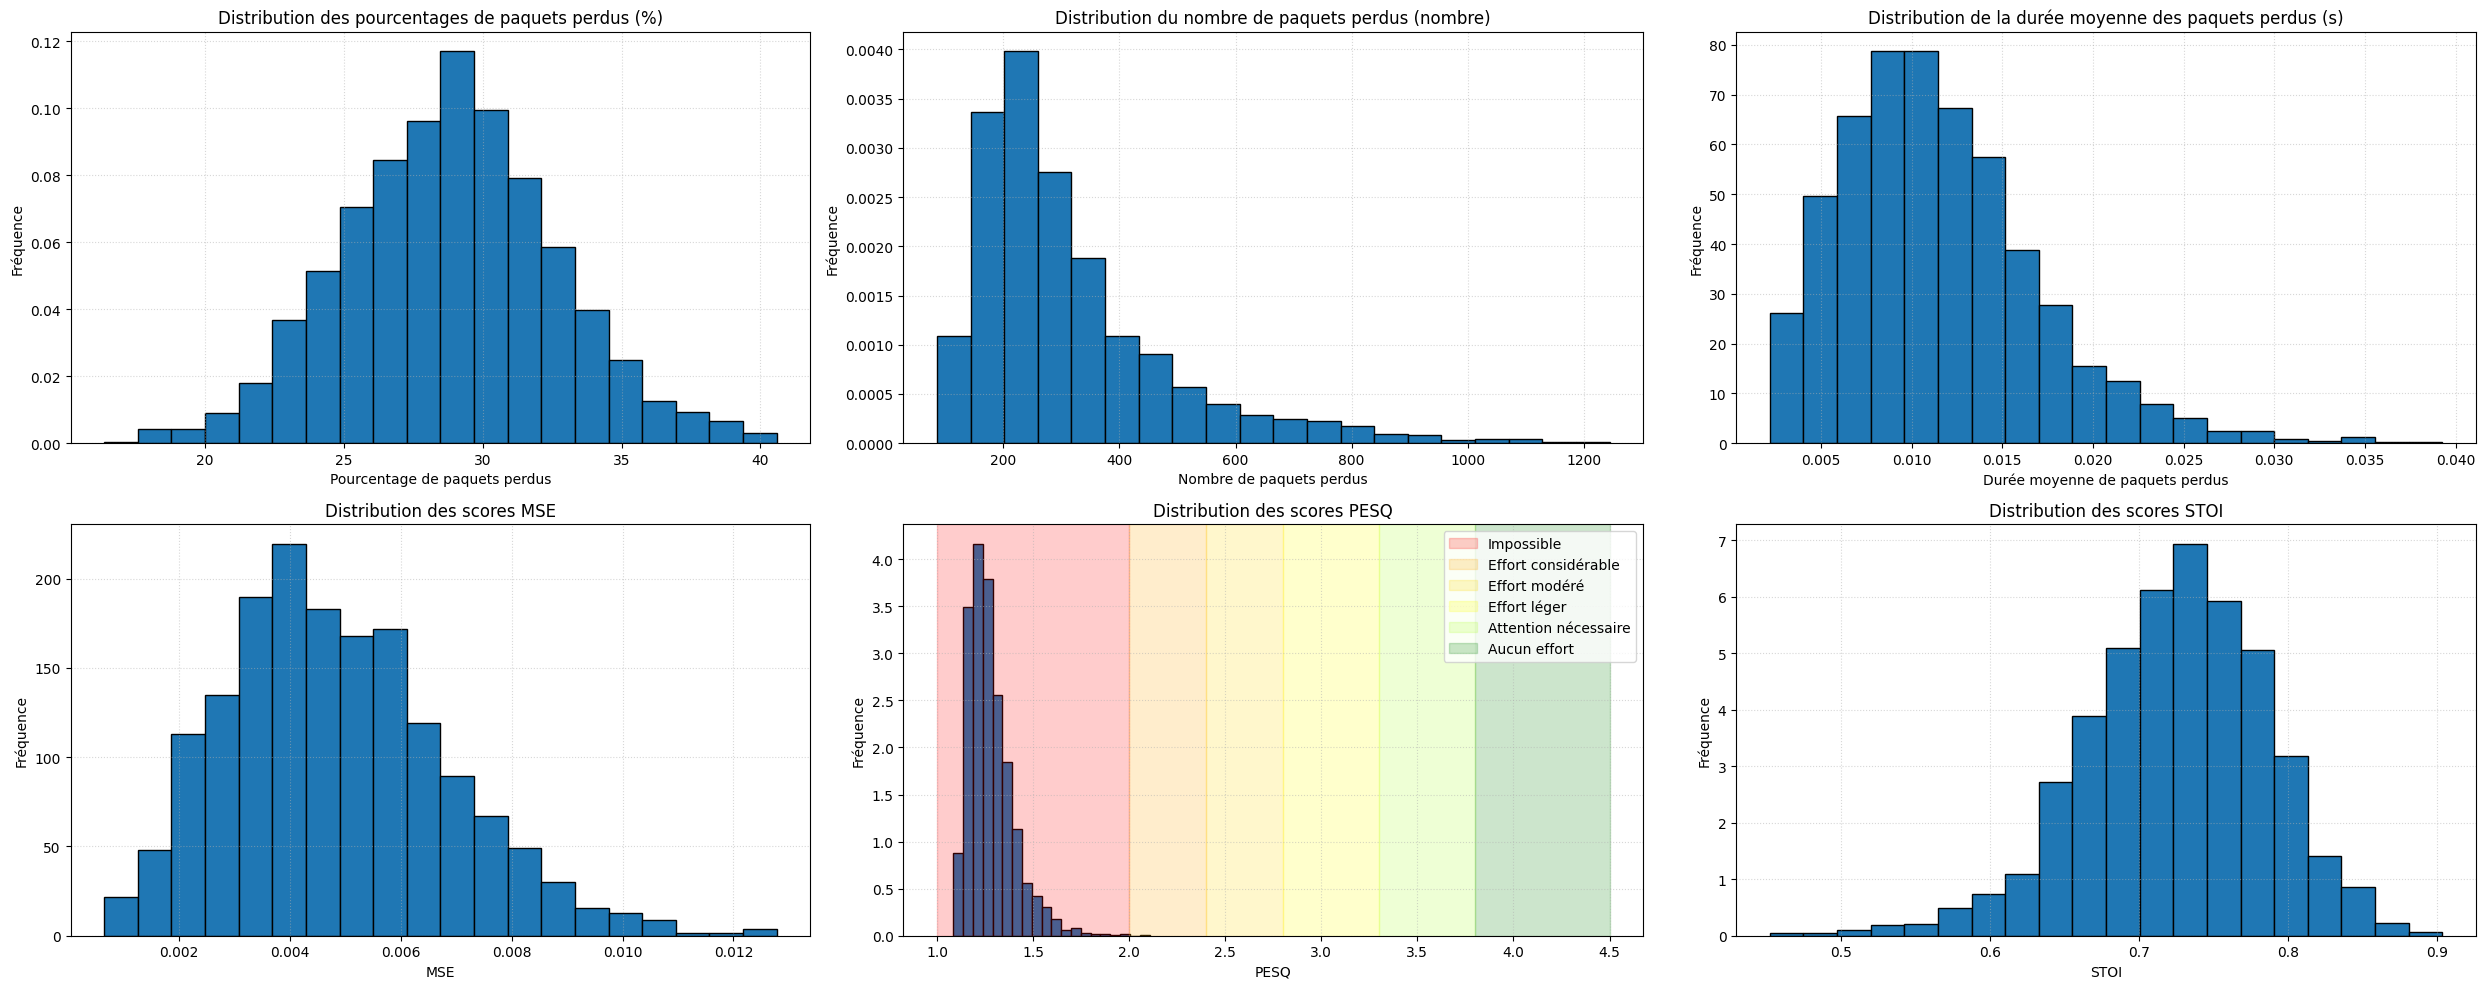

In [ ]:
print("Histogrammes du set de train :")
plot_histogrammes(histogrammes(X_train, Y_train))

Histogrammes du set de test :
Signal n° 782/782

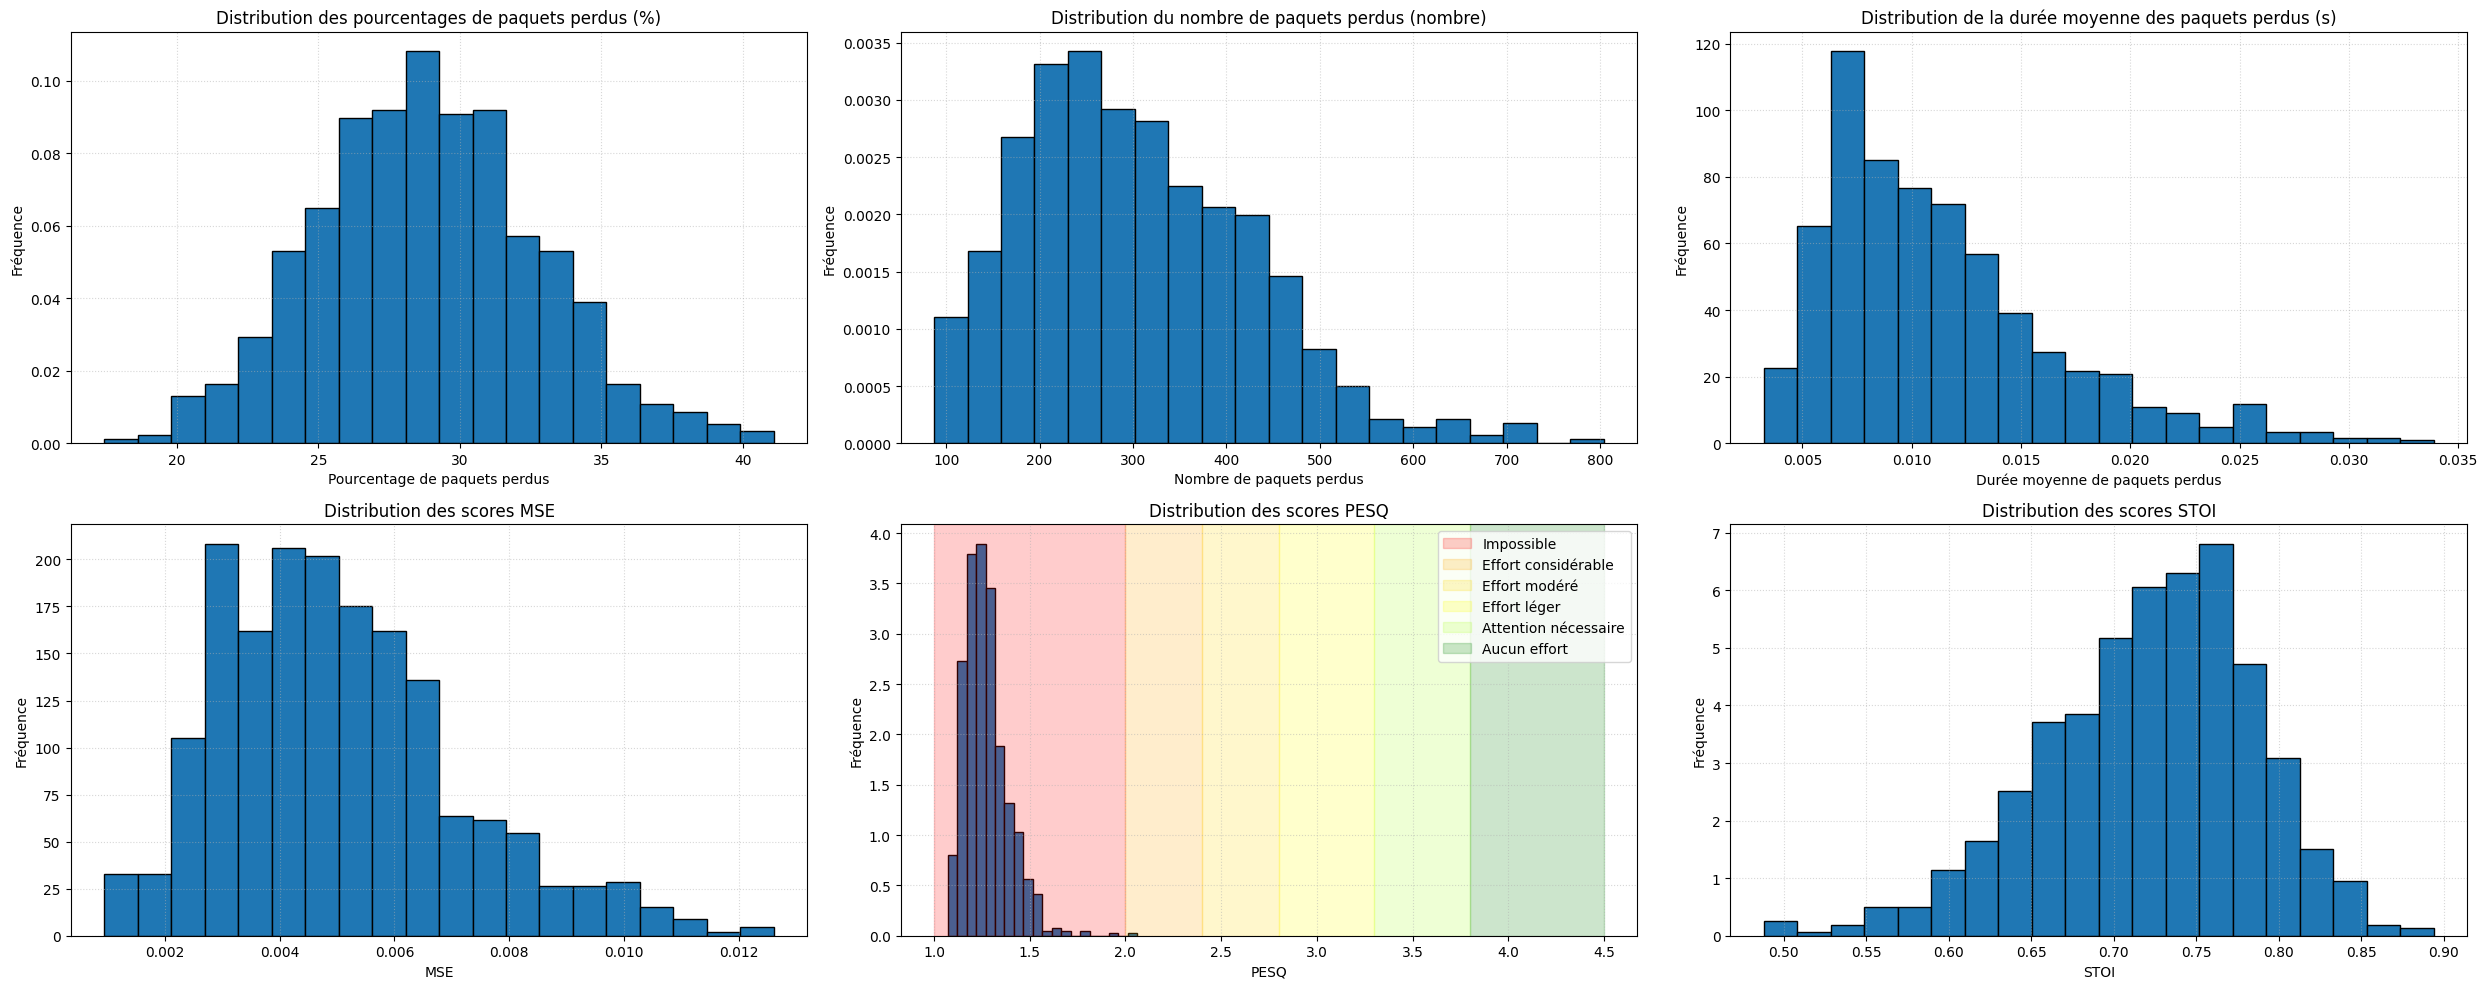

In [ ]:
print("Histogrammes du set de test :")
plot_histogrammes(histogrammes(X_test, Y_test))

# Baseline : Interpolation

Approche simple, naïve par interpolation des bouts manquants

In [44]:
def baseline_interpolation(signal_loss):
  signal_reconstruction = signal_loss.copy()
  paquets_perdus_estimes = False * np.ones(len(signal_loss))
  indices_paquets_perdus = np.where(signal_loss == 0.0)
  paquets_perdus_estimes[indices_paquets_perdus] = True
  paquets_perdus_dictionnary = true_blocks_dictionnary(paquets_perdus_estimes)
  for debut, duree in paquets_perdus_dictionnary.items():
    if debut == 0:
      valeur_debut, valeur_fin = 0, signal_loss[debut+duree]
    elif debut+duree == len(signal_loss):
      valeur_debut, valeur_fin = signal_loss[debut-1], 0
    else :
      valeur_debut, valeur_fin = signal_loss[debut-1], signal_loss[debut+duree]
    signal_reconstruction[debut:debut+duree] = np.linspace(valeur_debut, valeur_fin, duree)
  return signal_reconstruction

In [45]:
signal_reconstruction = baseline_interpolation(signal_loss)

In [46]:
IPython.display.Audio(signal_og, rate=samplerate)

In [47]:
IPython.display.Audio(signal_loss, rate=samplerate)

In [48]:
IPython.display.Audio(signal_reconstruction, rate=samplerate)

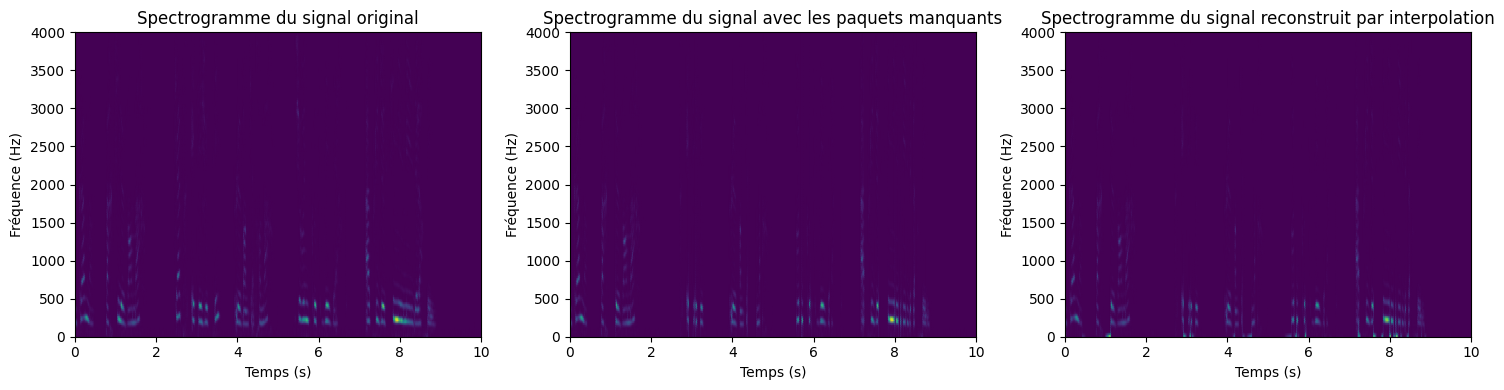

SNR du signal avec les paquets manquants : 4.737617159102988 dB
SNR du signal reconstruit par interpolation : 2.478391038358933 dB


In [49]:
nperseg = 256
f_stft_og, t_stft_og, amplitude_stft_og = stft(signal_og, samplerate, nperseg=nperseg)
f_stft_loss, t_stft_loss, amplitude_stft_loss = stft(signal_loss, samplerate, nperseg=nperseg)
f_stft_reconstruction, t_stft_reconstruction, amplitude_stft_reconstruction = stft(signal_reconstruction, samplerate, nperseg=nperseg)
# Tracer le spectrogramme
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].pcolormesh(t_stft_og, f_stft_og, np.abs(amplitude_stft_og), shading='gouraud', cmap='viridis')
axes[0].set_title("Spectrogramme du signal original")
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Fréquence (Hz)")
axes[1].pcolormesh(t_stft_loss, f_stft_loss, np.abs(amplitude_stft_loss), shading='gouraud', cmap='viridis')
axes[1].set_title("Spectrogramme du signal avec les paquets manquants")
axes[1].set_xlabel("Temps (s)")
axes[1].set_ylabel("Fréquence (Hz)")
axes[2].pcolormesh(t_stft_reconstruction, f_stft_reconstruction, np.abs(amplitude_stft_reconstruction), shading='gouraud', cmap='viridis')
axes[2].set_title("Spectrogramme du signal reconstruit par interpolation")
axes[2].set_xlabel("Temps (s)")
axes[2].set_ylabel("Fréquence (Hz)")
plt.tight_layout()
plt.show()

# Comparaison SNR
snr_loss = SNR(signal_og, signal_loss)
snr_reconstruction = SNR(signal_og, signal_reconstruction)
print(f"SNR du signal avec les paquets manquants : {snr_loss} dB")
print(f"SNR du signal reconstruit par interpolation : {snr_reconstruction} dB")

Signal n° 2/782

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Signal n° 782/782

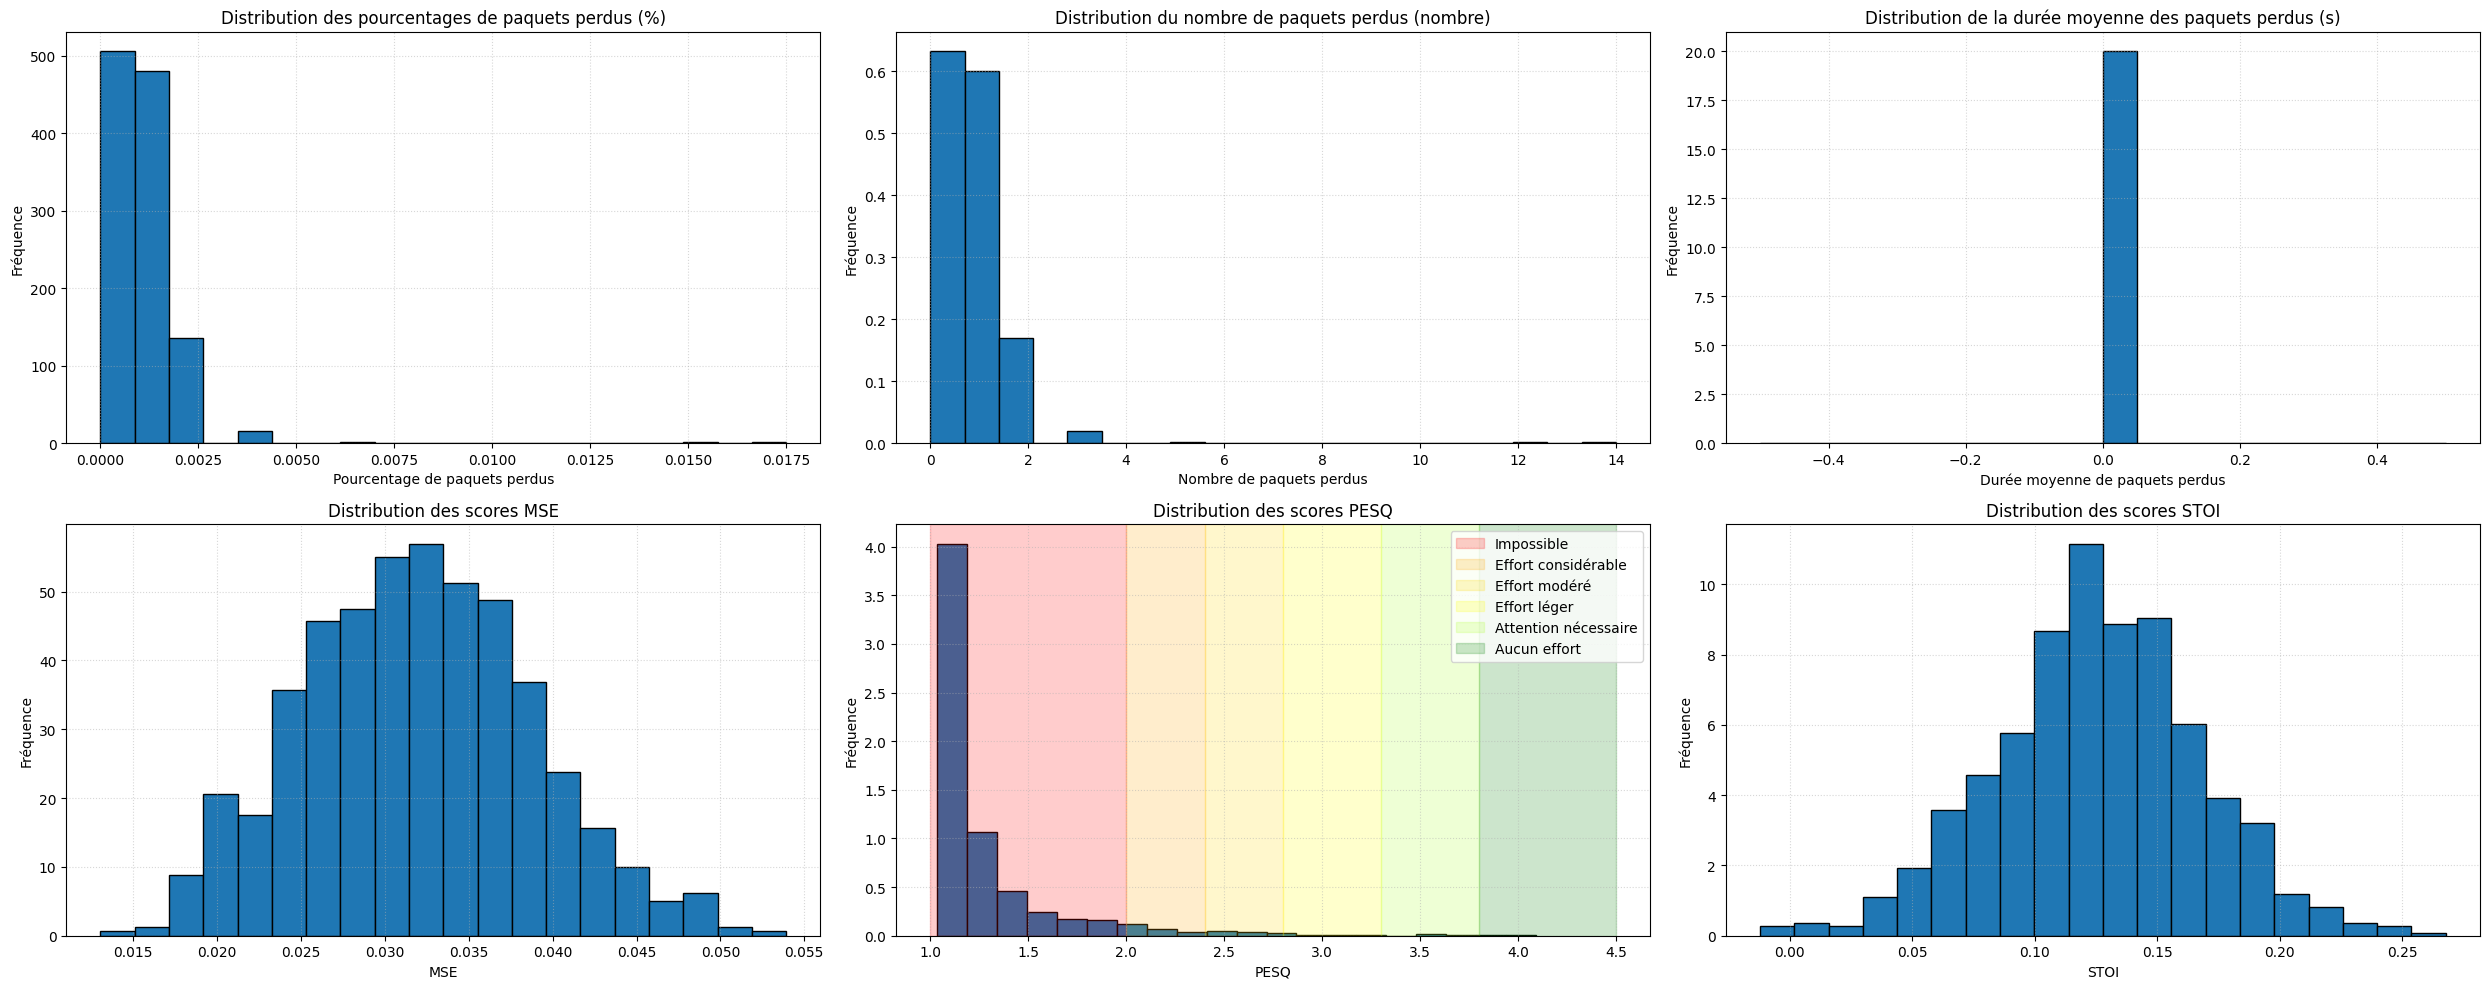

In [ ]:
# Interpolation sur tout le dataset
X_reconstruction = []
for i in range(len(X_test)):
  signal_loss = X_test[i]['data']
  signal_reconstruction = baseline_interpolation(signal_loss)
  X_reconstruction.append(signal_reconstruction)

plot_histogrammes(histogrammes(X_reconstruction, Y_train))

# Autre baseline : Interpolation par modèle d'Auto-Régression

In [ ]:
!python3.10 -m pip install statsmodels

In [50]:
from statsmodels.tsa.ar_model import AutoReg

def ar_interpolation(signal_loss , lag = 5):
    model = AutoReg(signal_loss, lags=lag)
    model_fit = model.fit()
    pred = model_fit.predict()
    return pred

In [51]:
idx = 145
signal_og = Y_train[idx]['data']
signal_loss = X_train[idx]['data']
signal_reconstruction = ar_interpolation(signal_loss, lag = 10)
signal_reconstruction[:10] = 0.0

In [52]:
IPython.display.Audio(signal_og, rate=samplerate)

In [53]:
IPython.display.Audio(signal_loss, rate=samplerate)

In [54]:
IPython.display.Audio(signal_reconstruction, rate=samplerate)

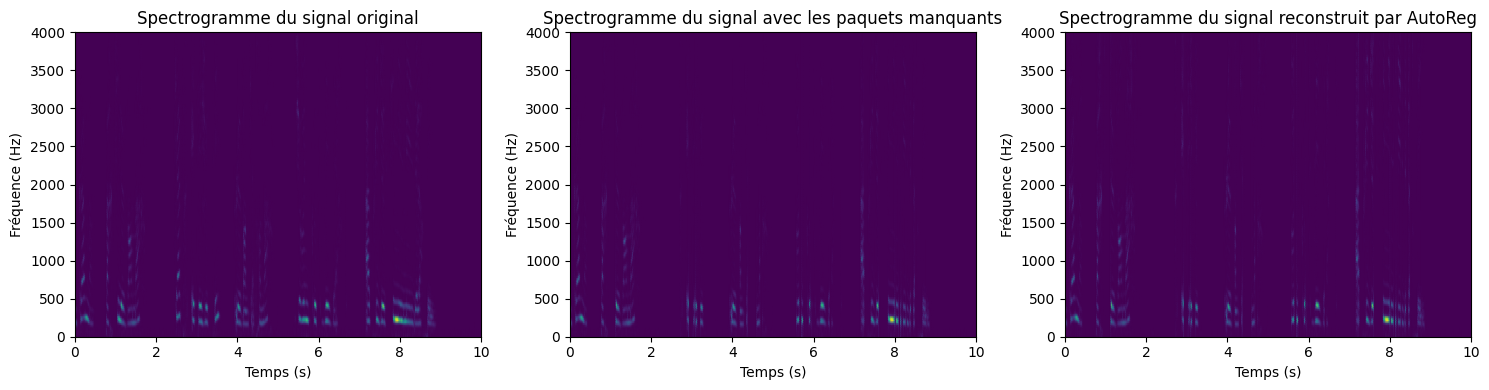

SNR du signal avec les paquets manquants : 4.737617159102988 dB
SNR du signal reconstruit par interpolation : 4.137751529407973 dB


In [55]:
nperseg = 256
f_stft_og, t_stft_og, amplitude_stft_og = stft(signal_og, samplerate, nperseg=nperseg)
f_stft_loss, t_stft_loss, amplitude_stft_loss = stft(signal_loss, samplerate, nperseg=nperseg)
f_stft_reconstruction, t_stft_reconstruction, amplitude_stft_reconstruction = stft(signal_reconstruction, samplerate, nperseg=nperseg)
# Tracer le spectrogramme
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].pcolormesh(t_stft_og, f_stft_og, np.abs(amplitude_stft_og), shading='gouraud', cmap='viridis')
axes[0].set_title("Spectrogramme du signal original")
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Fréquence (Hz)")
axes[1].pcolormesh(t_stft_loss, f_stft_loss, np.abs(amplitude_stft_loss), shading='gouraud', cmap='viridis')
axes[1].set_title("Spectrogramme du signal avec les paquets manquants")
axes[1].set_xlabel("Temps (s)")
axes[1].set_ylabel("Fréquence (Hz)")
axes[2].pcolormesh(t_stft_reconstruction, f_stft_reconstruction, np.abs(amplitude_stft_reconstruction), shading='gouraud', cmap='viridis')
axes[2].set_title("Spectrogramme du signal reconstruit par AutoReg")
axes[2].set_xlabel("Temps (s)")
axes[2].set_ylabel("Fréquence (Hz)")
plt.tight_layout()
plt.show()

# Comparaison SNR
snr_loss = SNR(signal_og, signal_loss)
snr_reconstruction = SNR(signal_og, signal_reconstruction)
print(f"SNR du signal avec les paquets manquants : {snr_loss} dB")
print(f"SNR du signal reconstruit par interpolation : {snr_reconstruction} dB")

100%|█████████████████████████████████████████████████████████████████████████████████| 782/782 [00:23<00:00, 32.60it/s]

Signal n° 1/100

Signal n° 100/100

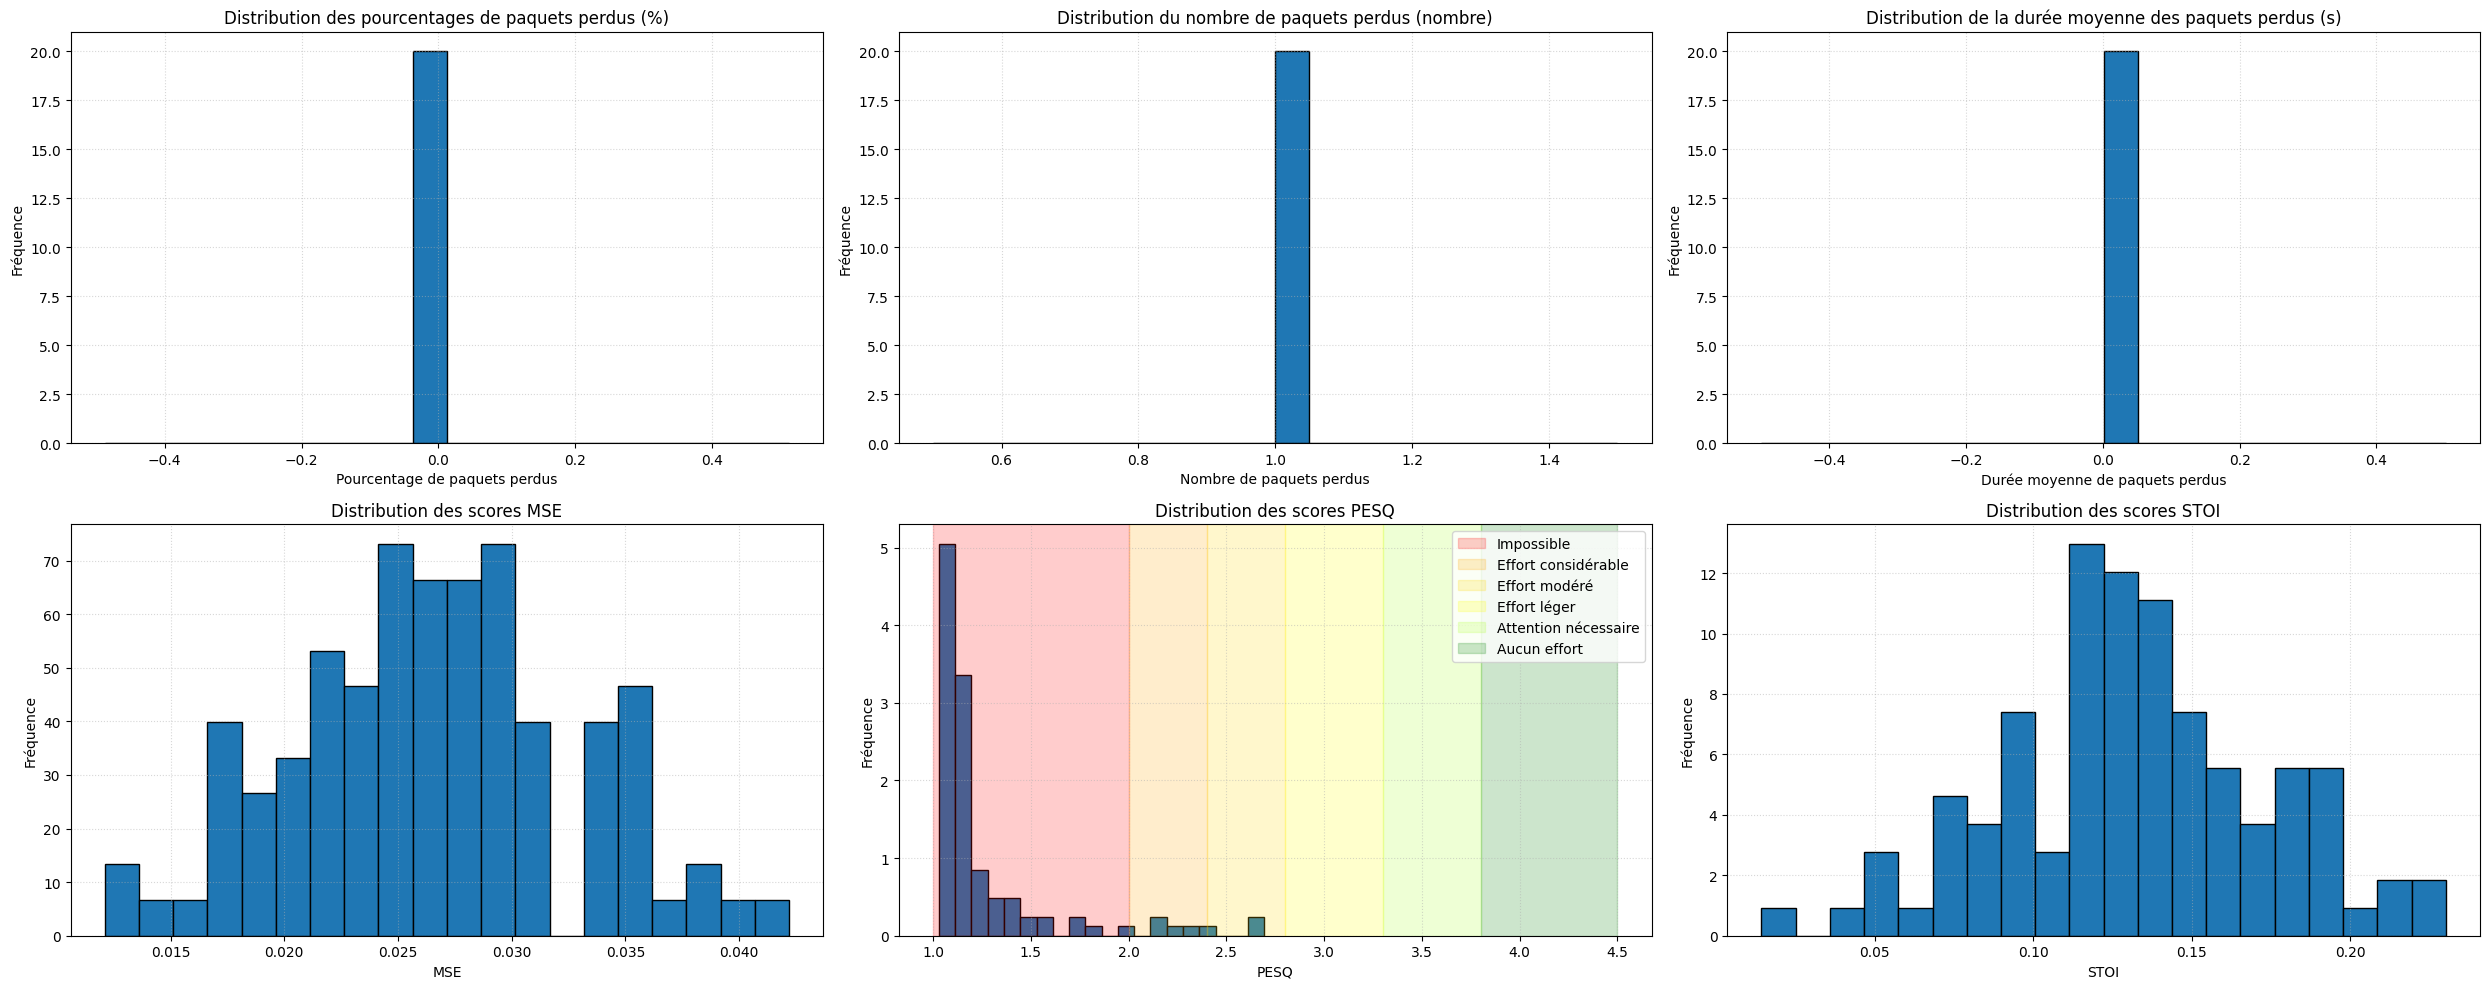

In [68]:
# Interpolation sur tout le dataset
from tqdm import tqdm
X_reconstruction = []
for i in tqdm(range(len(X_test))):
  signal_loss = X_test[i]['data']
  signal_reconstruction = ar_interpolation(signal_loss)
  signal_reconstruction[0:10] = 0
  X_reconstruction.append(signal_reconstruction)
    
plot_histogrammes(histogrammes(X_reconstruction[0:100], Y_train[0:100]))

◀◀◀◀◀◀ APPROCHES DEEP ▶▶▶▶▶▶

# Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
- un **Dataset** qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
- un **Dataloader** qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones



### DataSet

In [7]:
class MyDataset_FormeOnde(torch.utils.data.Dataset):

    def __init__(self, X, Y, nb_samples = None):
        """
        Il y a 2 listes à renseigner :
        - X : Celle pour les signaux AVEC perte (data)  : X_train (TRAIN) ou X_test (TEST)
        - Y : Celle pour les signaux SANS perte (labels): Y_train (TRAIN) ou Y_test (TEST)
        - X, Y sont déjà normalisés précedemment
        """
        # Chargement des dictionnaires data et labels
        #self.X = charger_donnees(chemin_data)
        #self.Y = charger_donnees(chemin_labels)
        self.X = X
        self.Y = Y
        # Chargement des signaux AVEC perte de paquets,
        # ---------- des signaux SANS ----------------,
        # ---------- du nom des signaux,
        # ---------- de la samplerate globale dans la mémoire.
        if nb_samples is None:
            self.signals_loss = np.array([x['data'] for x in self.X])
            self.signals_og = np.array([y['data'] for y in self.Y])
        else :
          longueur_signal = len(self.X[0]["data"])
          nombre_bouts = longueur_signal // nb_samples
          self.signals_loss = np.zeros((len(X) * nombre_bouts, longueur_signal // nombre_bouts)) # [bout, duree du bout]
          self.signals_og = np.zeros((len(Y) * nombre_bouts, longueur_signal // nombre_bouts)) # [bout, duree du bout]
          ####
          print(self.signals_loss.shape)
          print(self.signals_og.shape)
          ####
          longueur_bout = longueur_signal // nombre_bouts
          for i in range(len(self.X)):
            boutsX = [self.X[i]["data"][j:j+longueur_bout] for j in range(0, longueur_signal, longueur_bout)]
            boutsY = [self.Y[i]["data"][j:j+longueur_bout] for j in range(0, longueur_signal, longueur_bout)]
            for j in range(len(boutsX)):
              self.signals_loss[i * nombre_bouts + j] = boutsX[j]
              self.signals_og[i * nombre_bouts + j] = boutsY[j]
        # Chargement des noms et de la samplerate déjà vérifiée comme unique
        assert([x["nom"] for x in self.X] == [y["nom"] for y in self.Y])
        self.names = np.array([x['nom'] for x in self.X])
        self.samplerate = self.X[0]['samplerate']

    def __len__(self): #retourne le nombre de données dans le dataset
        assert(len(self.signals_loss)==len(self.signals_og))
        return len(self.signals_loss)

    def __getitem__(self,i):
      """
      retourne pour chaque indice i un couple (data_i, label_i),
      data_i le signal avec perte de paquets, potentiellement découpé
      label_i le signal original, sans perte de paquets, potentiellement découpé
      si spectre = True, on ne retourne plus les formes d'ondes mais les spectrogrammes à la place
      """

      # On transforme explicitement les np.array en tenseurs qu'on unsqueeze pour avoir des shapes [B, C=1, T]
      signal_loss = torch.tensor(self.signals_loss[i], dtype=torch.float32).unsqueeze(0)
      signal_og = torch.tensor(self.signals_og[i], dtype=torch.float32).unsqueeze(0)

      return signal_loss, signal_og

class DatasetVoice(Dataset):
    def __init__(self, chemin = ".", type_ = "train",  nb_samples = 1000, transform = None):
        types = ["train", "test", "train_small"]
        if type_ not in types:
            return Exception("Please provide a correct type among those : " + str(types)) 
        dicX, dicY = charger_donnees(os.path.join(chemin, "packet_loss", type_ )), charger_donnees(os.path.join(chemin, "voice_origin", type_ ))
        
        split = len(dicX[0]["data"]) // nb_samples
        self.X = torch.zeros(len(dicX) * split, len(dicX[0]["data"]) // split)#.to(device)
        self.y = torch.zeros(len(dicY) * split, len(dicY[0]["data"]) // split)#.to(device)
        step = len(dicX[0]["data"]) // split
        for i in tqdm(range(0, len(dicX))):
            dicX[i]["data"] = dicX[i]["data"] / np.max(np.abs(dicX[i]["data"]))
            dicY[i]["data"] = dicY[i]["data"] / np.max(np.abs(dicY[i]["data"]))
            splitsX = [dicX[i]["data"][j:j+step] for j in range(0, len(dicX[i]["data"]), step)]
            splitsY = [dicY[i]["data"][j:j+step] for j in range(0, len(dicY[i]["data"]), step)]
            if split == 1:
                splits = [dicX[i]["data"]]
            for j in range(len(splitsX)):
                self.X[i * split +  j] = torch.from_numpy(splitsX[j])#.to(device)
                self.y[i * split+ j] = torch.from_numpy(splitsY[j])#.to(device)
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        if transform:
            self.transform = transform.to(device)
        else:
            self.transform = None
    def __getitem__(self, i):
        feature, target = self.X[i], self.y[i]
        if self.transform:
            feature = self.transform(feature,)
            target = self.transform(target,)
            feature_abs = (feature.abs())
            target_abs = (target.abs())
            feature_abs /= feature_abs.max()
            target_abs /= target_abs.max()
            feature_angle = feature.angle()
            target_angle = target.angle()
            return (feature_abs, feature_angle,
            target_abs, target_angle)
        return feature, target
    def __len__(self):
        return len(self.X)

 

In [56]:
#chemin_data_train, chemin_labels_train = chemin + '/packet_loss/train', chemin + '/voice_origin/train'
#chemin_data_test, chemin_labels_test = chemin + '/packet_loss/test', chemin + '/voice_origin/test'
#dataset_train = MyDataset_FormeOnde(chemin_data_train, chemin_labels_train)
#dataset_test = MyDataset_FormeOnde(chemin_data_test, chemin_labels_test)

# Instancier le DataSet de Train et de Test
dataset_train = MyDataset_FormeOnde(X_train, Y_train, nb_samples = None)
dataset_test = MyDataset_FormeOnde(X_test, Y_test, nb_samples = None)

In [8]:
dataset_train_other = DatasetVoice(type_ = "train", nb_samples = 100)
dataset_test_other = DatasetVoice(type_ = "test", nb_samples = 100)
# Creating validation set
prop_eval = 0.1
prop_train = 0.9
dataset_eval_other, dataset_train_other  = random_split(dataset_train_other, [prop_eval, prop_train])
print("Taille train : ", len(dataset_train_other))
print("Taille test : ", len(dataset_test_other))
print("Taille eval : ", len(dataset_eval_other))

100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:07<00:00, 109.30it/s]


Taille train :  1524960
Taille test :  625600
Taille eval :  169440


### DataLoader

In [ ]:
from torch.utils.data import DataLoader
dataloader_train = DataLoader(dataset_train,
                              batch_size=16,
                              shuffle=True) #shuffle : garantit que les données sont mélangées aléatoirement à chaque époque d'entraînement (à chaque appel de enumerate)

dataloader_test = DataLoader(dataset_test,
                             batch_size=16,
                             shuffle=False)

In [ ]:
# On regarde comment accéder aux données du dataloader
# -----------------------------------
for batch_idx, (data, label) in enumerate(dataloader_train):
    print(f"Batch {batch_idx + 1}:")
    print("Nombre de signaux dans le batch:", len(data))
    print("\nData:", data)
    print('Data de shape:', data.shape)
    print("\nLabel:", label)
    print('Label de shape:', label.shape)
    break  # Retirez ce break pour parcourir tout le dataloader

Batch 1:
Nombre de signaux dans le batch: 16

Data: tensor([[[-0.0310, -0.0297, -0.0298,  ...,  0.0250, -0.0161, -0.0516]],

        [[ 0.0051,  0.0116,  0.0128,  ..., -0.1267, -0.1679, -0.1957]],

        [[ 0.0126,  0.0038, -0.0699,  ..., -0.0140, -0.0105, -0.0073]],

        ...,

        [[-0.0000, -0.0000, -0.0000,  ..., -0.1338, -0.1329, -0.1520]],

        [[ 0.0088, -0.0037,  0.0042,  ...,  0.0340,  0.0210,  0.0042]],

        [[ 0.2254,  0.2260,  0.2014,  ...,  0.0295,  0.0274,  0.0232]]])
Data de shape: torch.Size([16, 1, 80000])

Label: tensor([[[-0.0310, -0.0297, -0.0298,  ...,  0.0250, -0.0161, -0.0516]],

        [[ 0.0051,  0.0116,  0.0128,  ..., -0.1267, -0.1679, -0.1957]],

        [[ 0.0126,  0.0038, -0.0699,  ..., -0.0140, -0.0105, -0.0073]],

        ...,

        [[-0.2202, -0.3127, -0.3886,  ..., -0.1338, -0.1329, -0.1520]],

        [[ 0.0088, -0.0037,  0.0042,  ...,  0.0340,  0.0210,  0.0042]],

        [[ 0.1984,  0.1989,  0.1772,  ...,  0.0259,  0.0241,  0.020

In [9]:
batch_size = 32
train_loader_other= DataLoader(dataset_train_other, batch_size = batch_size, shuffle = True)
test_loader_other= DataLoader(dataset_test_other, batch_size = batch_size)
val_loader_other= DataLoader(dataset_eval_other, batch_size = batch_size)

# Pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et éventuellement de métriques complémentaires

In [ ]:
# Classe qui permet de logger l'évolution au fil des epochs de la loss sur l'ensemble train
class metric_logger:
   def __init__(self):

    """
    Initialisation : dictionnaires pour stocker les loss au fil de l'entraînement.
    En réalité, on stockera la moyenne pondérée de la loss sur chaque epoch.
    Ainsi, metrics_train et metrics_valid contiennent 1 valeur de la loss par epoch.
    """
    self.metrics_train = {'loss_mse': [],
                          'loss_masque_sans_perte':[],
                          'loss_masque_avec_perte':[]} # dictionnaire pour stocker la loss calculée sur le set de train

   def reset_metrics(self):
    """
    Réinitialise les métriques à chaque début d'epoch.
    A la fin de chaque epoch, on calculera la moyennne pondérée de la loss sur l'ensemble de l'époque (cf fonction log).
    Afin de calculer la moyenne sur une epoch :
    - on initialise loss à 0.0 parce qu'elle est utilisé pour accumuler la somme totale des loss sur une epoch
    - count sert à suivre le nombre total de données traités pendant une epoch et est initialisé à 0 également
    """
    self.current_metrics_train = {'loss_mse': 0.0,
                                  'loss_masque_sans_perte':0.0,
                                  'loss_masque_avec_perte':0.0,
                                  'count': 0}

   def update_metrics(self, batch_x, batch_y, batch_y_predicted):
    """
    Cette fontion met à jour les métriques pour un batch donné.
    - batch_x : signal avec perte de paquets
    - batch_y : signal orignal
    - batch_y_predicted : label prédit par le modèle
    - phase : 'train' ou 'valid' pour spécifier si on calcule la loss sur les données de train ou de validation.
    """
    # Calcul de la perte pour le batch
    loss = nn.MSELoss()
    batch_loss_mse = loss(batch_y_predicted, batch_y).item()
    batch_loss_masque_sans_perte = loss_masque_sans_perte(batch_x, batch_y, batch_y_predicted).item()
    batch_loss_masque_avec_perte = loss_masque_avec_perte(batch_x, batch_y, batch_y_predicted).item()
    # On multiplie la loss par la taille du batch pour calculer une moyenne pondérée (cf fonction log)
    self.current_metrics_train['loss_mse'] += batch_loss_mse * len(batch_x)
    self.current_metrics_train['loss_masque_sans_perte'] += batch_loss_masque_sans_perte * len(batch_x)
    self.current_metrics_train['loss_masque_avec_perte'] += batch_loss_masque_avec_perte * len(batch_x)
    self.current_metrics_train['count'] += len(batch_x)
    #return {'loss_mse': batch_loss_mse}

   def log(self):
    """
    Calcule et enregistre la moyenne des métriques à la fin de chaque époque.
    Moyenne des pertes sur 1 epoch = (\sum_i^B perte_i * taille_batch_i)/(\sum_i^B taille_batch_i) où B est le nombre de batchs par epoch.
    """
    if self.current_metrics_train['count'] > 0: #au cas où le dataloader est vide (ce qui arrive rarement)
        avg_loss_mse = self.current_metrics_train['loss_mse'] / self.current_metrics_train['count']
        avg_loss_masque_sans_perte = self.current_metrics_train['loss_masque_sans_perte'] / self.current_metrics_train['count']
        avg_loss_masque_avec_perte = self.current_metrics_train['loss_masque_avec_perte'] / self.current_metrics_train['count']
        self.metrics_train['loss_mse'].append(avg_loss_mse)
        self.metrics_train['loss_masque_sans_perte'].append(avg_loss_masque_sans_perte)
        self.metrics_train['loss_masque_avec_perte'].append(avg_loss_masque_avec_perte)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3 fonctions de loss :
# ---------------------
# 1. MSE,
# 2. MSE sur les parties sans perte
# 3. MSE sur les paquets perdus

#1
loss_sans_masque = nn.MSELoss()

#2
def loss_masque_sans_perte(batch_x, batch_y, batch_y_predicted):
    """
    Calcule la perte avec masque pour ignorer les zones effacées dans batch_x.
    Ce qui peut être interessant au début de l'entraînement
    (le modèle ne sait pas encore comment "remplir les trous")
    Args:
        batch_x (torch.Tensor): Signal d'entrée avec zones effacées (valeurs nulles).
        batch_y (torch.Tensor): Signal complet (target).
        batch_y_predicted (torch.Tensor): Signal prédit par le modèle.
    Returns:
        torch.Tensor: Perte moyenne calculée uniquement sur les zones non effacées.
    """
    # Créer un masque binaire : 1 où il y a des données, 0 là où un paquet est perdu
    mask = (batch_x != 0).float()
    # Calculer la perte élément par élément (MSE sans réduction)
    loss_fn = nn.MSELoss(reduction='none')
    loss = loss_fn(batch_y_predicted, batch_y)
    # Appliquer le masque : ignorer les pertes des zones effacées
    masked_loss = loss * mask
    # Moyenne de la perte sur les zones non effacées
    return masked_loss.sum() / mask.sum() if mask.sum() > 0 else masked_loss.sum()

#3

def loss_masque_avec_perte(batch_x, batch_y, batch_y_predicted):
  """
  Fait le contraire de la loss précédente : calcul la perte uniquement sur les zones effacées.
  Ce qui peut être intéressant à la fin de l'entraînement pour raffiner le modèle sur les zones effacées

  """
  # Créer un masque binaire : 0 où il y a des données, 1 là où un paquet est perdu
  mask = (batch_x == 0).float()
  # Calculer la perte élément par élément (MSE sans réduction)
  loss_fn = nn.MSELoss(reduction='none')
  loss = loss_fn(batch_y_predicted, batch_y)
  # Appliquer le masque : ignorer les pertes des zones effacées
  masked_loss = loss * mask
  # Moyenne de la perte sur les zones non effacées
  return masked_loss.sum() / mask.sum() if mask.sum() > 0 else masked_loss.sum()

In [ ]:
def train_model(model,n_epochs,chemin_vers_sauvegarde_model,loss):
  # Set so 'cuda:xx' if you have a GPU, xx is GPU index.
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  # Fonction de perte
  if loss == 'mse':
    loss = nn.MSELoss()
  elif loss == 'l1':
    loss = nn.L1Loss()
  # En premier lieu l'algorithme Adam comme Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
  # Initialisation de l'objet metric_logger
  logger = metric_logger()
  # On place le modèle dans le GPU si nécessaire
  model.to(device)

  print("Training started...")
  #count = 1
  for epoch in range(n_epochs):
      # Met le modèle en mode entraînement
      model.train()
      # Réinitialisation des métriques au début de chaque époque
      logger.reset_metrics()

      # TRAIN : On parcourt les données d'entraînement par batchs
      for batch_idx, (batch_x,batch_y) in enumerate(dataloader_train):
            # On affche à l'écran l'avancement de l'entrainement
          sys.stdout.write(f"\repoch {epoch+1}/{n_epochs} and batch {batch_idx+1}")#; count+=1
          sys.stdout.flush()
          # On transfère chaque batch de données et leurs labels sur le dispositif GPU/CPU approprié.
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
          # On remet à zéro les gradients des paramètres du modèle afin d'éviter l'accumulation des gradients d'un batch à l'autre.
          optimizer.zero_grad()
          # On fait une prédiction avec le modèle en utilisant les données d'entrée batch_x : forward pass
          batch_y_predicted = model(batch_x)
          # On calcule la perte entre les prédictions et les valeurs réelles à l'aide d'une fonction de loss
          if loss == 'combination':
            l = nn.MSELoss()(batch_y_predicted, batch_y) + 500*loss_masque_avec_perte(batch_x, batch_y, batch_y_predicted)
          else :
            l = loss(batch_y_predicted, batch_y)
          # loggez la loss sur le batch d'entraînement
          logger.update_metrics(batch_x, batch_y, batch_y_predicted)
          # Backpropagation : calcule des updates des paramètres
          l.backward()
          # Pas de descente de gradient stochastique ie mise à jour des paramètres (poids et biais) du modèle
          optimizer.step()

      # Log des métriques à la fin de chaque époque
      logger.log()

  # sauvegarde du model pour pouvoir le réutiliser ensuite
  torch.save(model, chemin_vers_sauvegarde_model)
  print("\n...Done!")

  return logger

In [94]:
def train_other(model, lr = 0.005, n_epochs = 100, print_step = 10, type_loss = "L2", proportion = 1., schedule = False ):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 20, 40, 60, 80], gamma=0.5)
    if type_loss.upper() == "L1":
        loss = torch.nn.L1Loss()
    else:
        loss = torch.nn.MSELoss()
    losses_eval = []
    losses_train = []
    pbar = tqdm(range(n_epochs))
    loss_memorized = 1000
    params_memorized = None
    index = -1
    
    try:
        for i in pbar:
    
    
            model.train()
            
            l = 0
            j = 0
            loss_train = 0
            
            for batch, true_val in train_loader_other:
                if j  >= proportion * len(train_loader_other):
                    break
                
                output = model(batch)
                #dif_target = true_val - batch
                #dif_output = true_val - output
                l = loss(output, true_val)
                j += 1
                l.backward()
                optimizer.step()
                loss_train += l.detach().item()
                optimizer.zero_grad()
            if schedule:
                scheduler.step()
            losses_train.append(loss_train / len(dataset_train_other))
            model.eval()
            with torch.no_grad():
                l = 0
                for batch,  true_val in val_loader_other:
                    output = model(batch)
                    l += loss(output, true_val)
    
                losses_eval.append(l.item() / len(dataset_eval_other))
                if i % print_step == 0:
                    print(f"Loss eval :  {losses_eval[-1]}")
                pbar.set_description("Processing with loss : " + str(losses_eval[-1]))

    except KeyboardInterrupt:
        print("Interruption")
    
    return losses_train, losses_eval

# Baseline avec un réseau de neurones

La baseline consiste en un simple modèle RNN (GRU).
Cependant, comme les signaux sont beaucoup trop longs, nous allons les découper par tranches de 100 échantillons pour avoir un modèle RNN de taille raisonnable.

In [101]:
class BaselineNet(nn.Module):
    def __init__(self, input_size = 100, output_size = 100):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size).to(device)
        self.input_size = input_size
        self.output_size = output_size
    def forward(self, batch):
        output = self.fc(batch,)
        output = F.sigmoid(output,)
        return output

In [102]:
# Instanciation du modèle
net = BaselineNet()
print("Nombre de paramètres : ", sum(p.numel() for p in net.parameters()))

Nombre de paramètres :  10100


In [103]:
# Entraînement
losses_train, losses_eval = train_other(net, n_epochs = 50, proportion = 0.2)

Processing with loss : 0.0003934971446468652:   2%|▊                                     | 1/50 [00:15<12:22, 15.15s/it]

Loss eval :  0.0003934971446468652


Processing with loss : 0.0003913449385573664:  22%|████████▏                            | 11/50 [02:50<10:01, 15.42s/it]

Loss eval :  0.0003913449385573664


Processing with loss : 0.0003916131650872451:  42%|███████████████▌                     | 21/50 [05:23<07:25, 15.36s/it]

Loss eval :  0.0003916131650872451


Processing with loss : 0.0003916131650872451:  42%|███████████████▌                     | 21/50 [05:26<07:30, 15.55s/it]

Interruption


In [106]:
torch.save(net.state_dict(), "Base.model")

In [109]:
# Résultats
x = torch.zeros(800, 100)
y = torch.zeros(800, 100)
ancien = torch.zeros(800, 100)
for i in tqdm(range(0, 800)):
    ancien[i] = dataset_test_other[i][0]
    x[i] = (net(dataset_test_other[i][0].view(1, -1)))
    y[i] = dataset_test_other[i][1]
x = x.flatten().cpu().detach().numpy()
ancien = ancien.flatten().cpu().detach().numpy()
y = y.flatten().cpu().detach().numpy()

100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 1315.47it/s]


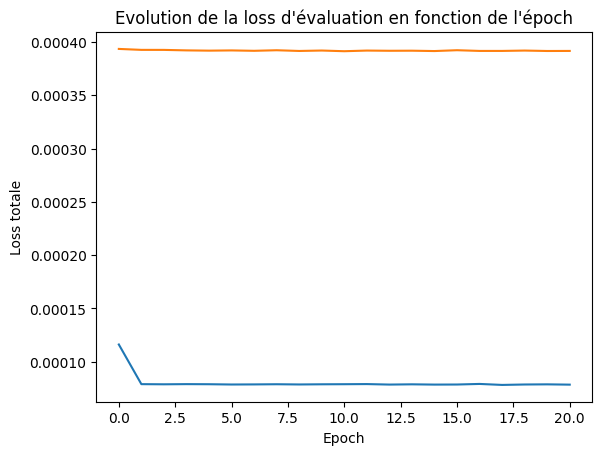

<Figure size 640x480 with 0 Axes>

In [114]:
plt.xlabel("Epoch")
plt.ylabel("Loss totale")
plt.title("Evolution de la loss d'évaluation en fonction de l'époch")
plt.plot(np.arange(len(losses_train)), losses_train)
plt.plot(np.arange(len(losses_eval)), losses_eval)
plt.show()
plt.savefig("loss_base")

#import matplotlib.image as mpimg
#img_chemin = chemin + "model_backup/nn-baseline-loss.png"
#img = mpimg.imread(img_chemin)
#plt.imshow(img)
#plt.axis('off')  # Supprime les axes pour une meilleure visibilité
#plt.show()

La baseline n'apprend pas à généraliser.

In [115]:
IPython.display.Audio(ancien, rate=8000) #with packet loss

In [116]:
IPython.display.Audio(x, rate=8000)

Le modèle a rendu l'audio encore plus mauvais.

In [118]:
mse_score_parfait = MSE(y, y)
mse_score_initial = MSE(y, ancien)
mse_score_reconstruction = MSE(y, x)
print("MSE témoin parfait", mse_score_parfait)
print("MSE avant reconstruction :", mse_score_initial)
print("MSE après reconstruction :", mse_score_reconstruction)

MSE témoin parfait 0.0
MSE avant reconstruction : 0.006237749481201172
MSE après reconstruction : 0.010805887603759766


In [119]:
snr_score_parfait = SNR(y, y) #donne +inf : logique => métrique pas top pour ce genre de problèmes de paquet loss
snr_score_initial = SNR(y, ancien)
snr_score_reconstruction = SNR(y, x)
print("SNR témoin parfait", snr_score_parfait)
print("SNR avant reconstruction :", snr_score_initial)
print("SNR après reconstruction :", snr_score_reconstruction)

SNR témoin parfait inf
SNR avant reconstruction : 3.323184549808502
SNR après reconstruction : 0.9368593990802765


/tmp/ipykernel_108425/3227946914.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10(np.sum(x**2) / np.sum((x - x_reconstructed)**2))


In [122]:
samplerate =8000 
stoi_score_parfait = stoi(y, y, samplerate)
stoi_score_initial = stoi(y, ancien, samplerate)
stoi_score_reconstruction = stoi(y, x, samplerate)
print("STOI témoin parfait :", stoi_score_parfait)
print("STOI avant reconstruction :", stoi_score_initial)
print("STOI après reconstruction :", stoi_score_reconstruction)

STOI témoin parfait : 0.9999999999999994
STOI avant reconstruction : 0.4984813465339311
STOI après reconstruction : 0.36599597907173004


Tous les scores ont été dégradés.

In [123]:
score_model = score(dataset_eval_other)
print("Score model : ", score_model)
score_base = score(dataset_eval_other, with_model = False)
print("Score base: ", score_base)

NameError: name 'score' is not defined

# Architectures sur le spectrogramme Seq2Seq :

Nous avons un problème de type many-to-many qui se prête bien à l'utilisation d'un modèle Seq2Seq.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size = 100, hidden_size = 128, num_layers = 1, bidirectional = False, dropout = 0.):
        super().__init__()
        self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,
                          bidirectional = bidirectional, dropout = dropout, batch_first = True).to(device)
        self.bidirectional = int(bidirectional) + 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
    def forward(self, batch):
        #batch
        output, hiddens = self.rnn(batch, )
        h = torch.cat((hiddens[-2,:,:], hiddens[-1,:,:]), dim=-1).unsqueeze(0) # Derniere layer, deux directions
        #c = torch.cat((cells[-2,:,:], cells[-1,:,:]), dim=-1).unsqueeze(0)
        #h, c = hiddens,cells
        return h

class Decoder(nn.Module):
    def __init__(self, input_size = 100, hidden_size = 256, output_dim = 100, num_layers = 2, dropout = 0.):
        super().__init__()
        self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size , num_layers = num_layers,
                           dropout = dropout, batch_first = True, bidirectional = False).to(device)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.fc = nn.Linear(hidden_size , output_dim).to(device)
    def forward(self, batch, h):

        outputs, _ = self.rnn(batch, h)
        #outputs = outputs.squeeze(1)
        preds = self.fc(outputs)
        return preds

class Seq2Seq(nn.Module):
    def __init__(self,input_size = 100, hidden_size = 128, output_dim = 100):
        super().__init__()
        self.enc = Encoder(input_size = input_size, num_layers = 2, hidden_size = hidden_size, bidirectional = True)
        self.dec = Decoder(input_size = input_size, output_dim = input_size, hidden_size = hidden_size * 2, num_layers = 1,)
    def forward(self, batch):
        batch = batch.unsqueeze(1)
        h = self.enc(batch)
        output = self.dec(batch, h)
        return output.squeeze(1)

In [ ]:
torch.backends.cudnn.benchmark = True
model_seq = Seq2Seq()
train_other(model_seq, )

In [ ]:
torch.save(model_seq.state_dict(), "Seq2seq.model")

In [ ]:
model_seq = Seq2Seq()
model_seq.load_state_dict(torch.load("Seq2seq.model", weights_only=True))

In [ ]:
losses_new = train_other(model_seq, n_epochs = 300)

# Architecture U-Net sur le spectrogramme :

Structure de type encodeur - décodeur avec des courts-circuits entre les deux (conçu pour les images : donc ok pour les spectrogrammes) :
- Encodeur (downsampling) : Réduction progressive de la taille spatiale via des convolutions suivies de pooling.
- Bottleneck : Une couche ou un bloc intermédiaire qui combine toutes les informations extraites (courts-circuits).
- Decodeur (upsampling) : Reconstruction progressive de l'information originale via des convolutions transposées ou upsampling.

Nous avons mis au point un modèle UNET, et nous avons considéré plusieurs approches différentes:

* Prédire la magnitude du spectrogramme : cette méthode permet de prédire une meilleure magnitude, cependant, utiliser la phase de l'exemple d'entrée réduit drastiquement les performances.
* Prédire indépendemment la partie réelle et la partie imaginaire : cette méthode n'est pas viable, car le modèle ne semble pas pouvoir apprendre de motifs intéressants.
* Prédire la phase : on peut représenter la phase comme deux canaux avec d'un côté les cosinus de la phase et de l'autre les sinus de la phase.

In [10]:
def train_unet(model, lr = 0.005, n_epochs = 100, print_step = 10, type_loss = "L2", proportion = 1. ):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 20, 40, 60, 80], gamma=0.5)
    if type_loss.upper() == "L1":
        loss = torch.nn.L1Loss()
    else:
        loss = torch.nn.MSELoss()
    losses_eval = []
    losses_train = []
    pbar = tqdm(range(n_epochs))
    loss_memorized = 1000
    params_memorized = None
    index = -1

    try:
        for i in pbar:


            model.train()

            l = 0
            j = 0
            loss_train = 0

            for batch, phase, true_val, true_phase in train_loader_other:
                if j  >= proportion * len(train_loader_other):
                    break

                output = model(batch)
                #dif_target = true_val - batch
                #dif_output = true_val - output
                l = loss(output, true_val)
                j += 1
                l.backward()
                optimizer.step()
                loss_train += l.detach().item()
                optimizer.zero_grad()
            scheduler.step()
            losses_train.append(loss_train / len(dataset_train_other))
            model.eval()
            with torch.no_grad():
                l = 0
                for batch, _,  true_val, _ in val_loader_other:
                    output = model(batch)
                    l += loss(output, true_val)

                losses_eval.append(l.item() / len(dataset_eval_other))
                if i % print_step == 0:
                    print(f"Loss eval :  {losses_eval[-1]}")
                pbar.set_description("Processing with loss : " + str(losses_eval[-1]))
                if losses_eval[-1] < loss_memorized:
                    loss_memorized = losses_eval[-1]
                    params_memorized = unet.state_dict()
                    index = i
    except KeyboardInterrupt:
        print("Interruption")

    return losses_train, losses_eval, params_memorized, loss_memorized, index

In [11]:
transform = T.Spectrogram( n_fft=511, hop_length=313, power = None, )
dataset_train_other = DatasetVoice(nb_samples = 80000, transform = transform)

100%|█████████████████████████████████████████████████████████████████████████████| 2118/2118 [00:00<00:00, 2515.77it/s]


In [12]:
prop_eval = 0.1
dataset_eval_other, dataset_train_other = random_split(dataset_train_other, [prop_eval, 1 -prop_eval])

In [13]:
batch_size = 32
train_loader_other = DataLoader(dataset_train_other, batch_size = batch_size,)
val_loader_other = DataLoader(dataset_eval_other, batch_size = batch_size)

In [ ]:
class UNet_interpolation_phase(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.enc1 = self.down_conv(3, 16)
        self.enc2 = self.down_conv(16, 32)
        self.enc3 = self.down_conv(32, 64)
        self.enc4 = self.down_conv(64, 128)
        self.pool = nn.MaxPool2d(2, 2,)
        self.up1 = self.up(256)
        self.up2 = self.up(128)
        self.up3 = self.up(64)
        self.up4 = self.up(32)
        self.dec1 = self.up_conv(256, 128)
        self.dec2 = self.up_conv(128, 64)
        self.dec3 = self.up_conv(64, 32)
        self.dec4 = self.up_conv(32, 16)
        self.out = nn.Conv2d(16, 3, kernel_size = 1)
        self.bottom1 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bottom2 = nn.Conv2d(256, 256, 3, padding = 1)
        self.tanh = nn.Tanh()
    def down_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

        )
    def up(self, in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    def up_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
                            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )
    def forward(self, batch):
        e1 = self.enc1(batch)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.bottom2(self.bottom1(self.pool(e4)))
        d1 = self.up1(e5)

        # batch x Cannals x height x width
        d1 = torch.cat([e4, d1], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)

        # batch x Cannals x height x width

        d2 = torch.cat([e3, d2,], dim = 1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)

        d3 = torch.cat([e2, d3,], dim = 1)
        d3 = self.dec3(d3)
        d4 = self.up4(d3)


        d4 = torch.cat([e1, d4,], dim = 1)
        d4 = self.dec4(d4)
        out = self.out(d4)
        out = self.tanh(out)
        return out.squeeze(1)

In [14]:
class UNet_interpolation3(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.enc1 = self.down_conv(1, 16)
        self.enc2 = self.down_conv(16, 32)
        self.enc3 = self.down_conv(32, 64)
        self.enc4 = self.down_conv(64, 128)
        self.pool = nn.MaxPool2d(2, 2,)
        self.up1 = self.up(256)
        self.up2 = self.up(128)
        self.up3 = self.up(64)
        self.up4 = self.up(32)
        self.dec1 = self.up_conv(256, 128)
        self.dec2 = self.up_conv(128, 64)
        self.dec3 = self.up_conv(64, 32)
        self.dec4 = self.up_conv(32, 16)
        self.out = nn.Conv2d(16, 1, kernel_size = 1)
        self.bottom1 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bottom2 = nn.Conv2d(256, 256, 3, padding = 1)
        self.sigmoid = nn.Sigmoid()
    def down_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

        )
    def up(self, in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    def up_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
                            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )
    def forward(self, batch):
        batch = batch.unsqueeze(1)
        e1 = self.enc1(batch)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.bottom2(self.bottom1(self.pool(e4)))
        d1 = self.up1(e5)

        # batch x Cannals x height x width

        d1 = torch.cat([e4, d1], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)

        # batch x Cannals x height x width

        d2 = torch.cat([e3, d2,], dim = 1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)

        d3 = torch.cat([e2, d3,], dim = 1)
        d3 = self.dec3(d3)
        d4 = self.up4(d3)


        d4 = torch.cat([e1, d4,], dim = 1)
        d4 = self.dec4(d4)
        out = self.out(d4)
        out = self.sigmoid(out)
        return out.squeeze(1)

In [ ]:
class UNet_interpolation5(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.enc1 = self.down_conv(1, 16)
        self.enc2 = self.down_conv(16, 32)
        self.enc3 = self.down_conv(32, 64)
        self.enc4 = self.down_conv(64, 128)
        self.pool = nn.MaxPool2d(2, 2,)
        self.up1 = self.up(256)
        self.up2 = self.up(128)
        self.up3 = self.up(64)
        self.up4 = self.up(32)
        self.dec1 = self.up_conv(256, 128)
        self.dec2 = self.up_conv(128, 64)
        self.dec3 = self.up_conv(64, 32)
        self.dec4 = self.up_conv(32, 16)
        self.out = nn.Conv2d(16, 1, kernel_size = 1)
        self.bottom1 = nn.Conv2d(128, 256, 5, padding = 2)
        self.bottom2 = nn.Conv2d(256, 256, 5, padding = 2)
        self.sigmoid = nn.Sigmoid()
    def down_conv(self, in_channels, out_channels, kernel_size = 5):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 2, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 2, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

        )
    def up(self, in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    def up_conv(self, in_channels, out_channels, kernel_size = 5):
        return nn.Sequential(
                            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = 2, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 2, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )
    def forward(self, batch):
        batch = batch.unsqueeze(1)
        e1 = self.enc1(batch)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.bottom2(self.bottom1(self.pool(e4)))
        d1 = self.up1(e5)

        # batch x Cannals x height x width
        d1 = torch.cat([e4, d1], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)

        # batch x Cannals x height x width

        d2 = torch.cat([e3, d2,], dim = 1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)

        d3 = torch.cat([e2, d3,], dim = 1)
        d3 = self.dec3(d3)
        d4 = self.up4(d3)


        d4 = torch.cat([e1, d4,], dim = 1)
        d4 = self.dec4(d4)
        out = self.out(d4)
        out = self.sigmoid(out)
        return out.squeeze(1)

In [15]:
unet = UNet_interpolation3().to(device)

In [ ]:
torch.backends.cudnn.benchmark = True
losses_train, losses_eval, params_mem, loss_mem, index_mem = train_unet(unet, lr = 0.02, n_epochs = 250, type_loss = "L1", proportion = 0.2)

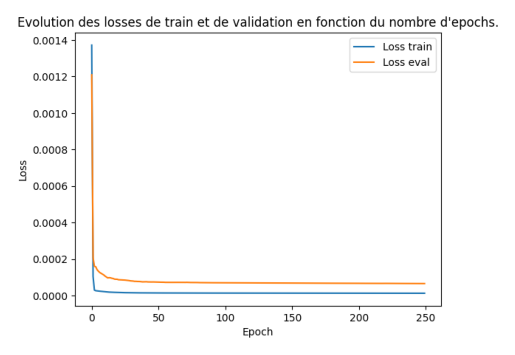

In [ ]:
plt.plot(losses_train, label = "Loss train")
plt.plot(losses_eval, label = "Loss eval")
plt.title("Evolution des losses de train et de validation en fonction du nombre d'epochs.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#img_chemin = chemin + "model_backup/u-net-loss.png"
#img = mpimg.imread(img_chemin)
#plt.imshow(img)
#plt.axis('off')
#plt.show()

In [ ]:
torch.save(unet.state_dict(), "Unet3.model")

In [23]:
weights = torch.load(chemin+"/Unet3.model", weights_only = True)
unet = UNet_interpolation3().to(device)
unet.load_state_dict(weights)


<All keys matched successfully>

In [17]:
dataset_test_other = DatasetVoice(nb_samples = 80000, type_ = "test", transform = transform)

100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 3330.66it/s]


Index choisi :  155


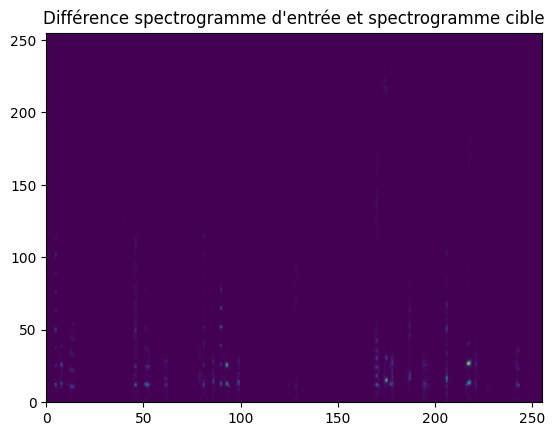

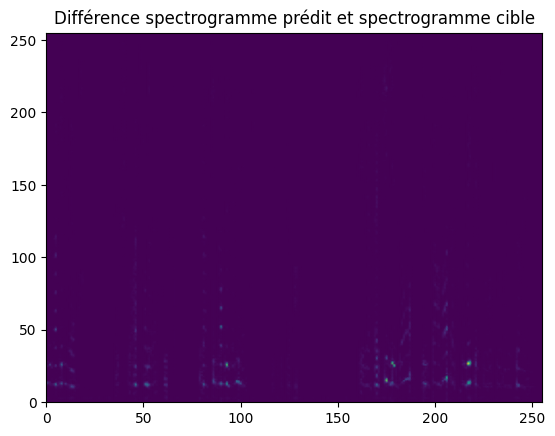

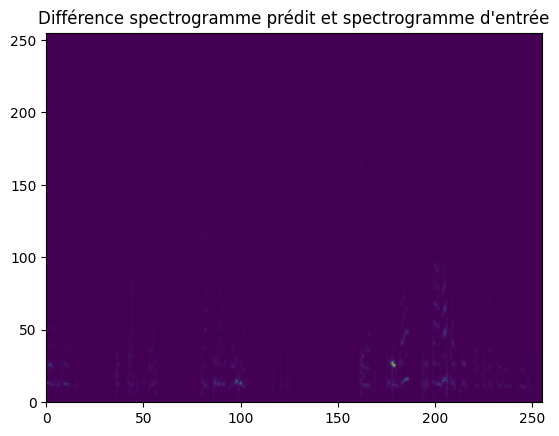

In [24]:
dataset = dataset_eval_other
index = np.random.randint(len(dataset))
print("Index choisi : ", index)
pred = unet(dataset[index][0].unsqueeze(0)).squeeze(0)
plt.title("Différence spectrogramme d'entrée et spectrogramme cible")
plt.pcolormesh(np.arange(0, 256), np.arange(0, 256), np.abs( dataset[index][0].cpu().detach().numpy() - dataset[index][2].cpu().detach().numpy() ) , shading='gouraud', cmap='viridis')
plt.show()
plt.title("Différence spectrogramme prédit et spectrogramme cible")
plt.pcolormesh(np.arange(0, 256), np.arange(0, 256), np.abs( dataset[index][2].cpu().detach().numpy() - pred.cpu().detach().numpy() ) , shading='gouraud', cmap='viridis')
plt.show()
plt.title("Différence spectrogramme prédit et spectrogramme d'entrée")
plt.pcolormesh(np.arange(0, 256), np.arange(0, 256), np.abs( dataset[index][0].cpu().detach().numpy() - pred.cpu().detach().numpy() ) , shading='gouraud', cmap='viridis')
plt.show()
phase = dataset[index][1]
amp = pred
full = torch.polar(amp.cpu().detach(), phase.cpu().detach())
signal = T.InverseSpectrogram(n_fft = 511, hop_length = 313)(full).cpu().detach().numpy()
full_original = torch.polar(dataset[index][2].cpu().detach(), dataset[index][3].cpu().detach())
full_lost = torch.polar(dataset[index][0].cpu().detach(), dataset[index][1].cpu().detach())
original_signal = T.InverseSpectrogram(n_fft = 511, hop_length = 313)(full_original).cpu().detach().numpy()
lost_signal = T.InverseSpectrogram(n_fft = 511, hop_length = 313)(full_lost).cpu().detach().numpy()

In [69]:
audio1 = IPython.display.Audio(signal, rate = 8000)
audio2 = IPython.display.Audio(original_signal, rate = 8000)
audio3 = IPython.display.Audio(lost_signal, rate = 8000)
pesq_predit =pesq(8000, original_signal, signal, 'nb')
pesq_lost = pesq(8000, original_signal, lost_signal, 'nb')
pesq_origin = pesq(8000, original_signal, original_signal, 'nb')
stoi_predit = stoi(original_signal, signal, 8000)
stoi_lost = stoi(original_signal, lost_signal, 8000)
stoi_origin = stoi(original_signal, original_signal, 8000)
mse_predit = ((original_signal - signal) ** 2).sum()
mse_lost = ((original_signal - lost_signal) ** 2).sum()
mse_origin = 0
print(f"Audio prédit (PESQ =  {pesq_predit} | STOI = {stoi_predit} | MSE = {mse_predit:.4f} ) ")
IPython.display.display(audio1)
print(f"Audio cible (PESQ =  {pesq_origin} | STOI = {stoi_origin} | MSE = {mse_origin:.4f} ) ")
IPython.display.display(audio2)
print(f"Audio de base (PESQ =  {pesq_lost} | STOI = {stoi_lost} | MSE = {mse_lost:.4f} ) ")
IPython.display.display(audio3)

Audio prédit (PESQ =  1.5043262243270874 | STOI = 0.7881093258632242 | MSE = 0.0881 ) 


Audio cible (PESQ =  4.548638343811035 | STOI = 0.9999999999999951 | MSE = 0.0000 ) 


Audio de base (PESQ =  1.4259774684906006 | STOI = 0.794752400808722 | MSE = 0.0745 ) 


In [25]:
def score_unet(dataset_train, model = None, number_examples = None):
    scores_predict = {"MSE" : [] , "SNR" : [] , "PESQ" : []  , "STOI" : [] }
    scores_old = {"MSE" : [] , "SNR" : [] , "PESQ" : []  , "STOI" : [] }
    ist = T.InverseSpectrogram(n_fft = 511, hop_length = 313).to(device)
    train_loader = DataLoader(dataset, batch_size = batch_size)
    i = 0
    for x, phase_x,  y, phase_y in tqdm(dataset):
        if i == number_examples:
            break
        i += 1
        x_old = x
        x = model(x.unsqueeze(0)).squeeze(0)
        x = torch.polar(x, phase_x)
        y = torch.polar(y, phase_y)
        x = ist(x)
        y = ist(y)
        x, y = x.cpu().detach().numpy(), y.cpu().detach().numpy()
        mse_score = ((y - x) ** 2).sum() / len(x)
        pesq_score = pesq(8000, y, x, "nb")
        stoi_score = stoi(y, x, 8000)
        scores_predict["MSE"].append(mse_score)
        scores_predict["PESQ"].append(pesq_score)
        scores_predict["STOI"].append(stoi_score)
        x_old = torch.polar(x_old, phase_x)
        x_old = ist(x_old)
        x_old, y = x_old.cpu().detach().numpy(), y
        power_noise = ((y - x) ** 2).sum() / len(x)
        power_y = (y ** 2).sum() / len(y)
        snr_score = 10 * np.log10(power_y / mse_score)
        scores_predict["SNR"].append(snr_score)
        mse_score = ((y - x_old) ** 2).sum() / len(x_old)
        pesq_score = pesq(8000, y, x_old, "nb")
        stoi_score = stoi(y, x_old, 8000)
        scores_old["MSE"].append(mse_score)
        scores_old["PESQ"].append(pesq_score)
        scores_old["STOI"].append(stoi_score)

        power_noise = ((y - x_old) ** 2).sum() / len(x_old)
        snr_score = 10 * np.log10(power_y / mse_score)
        scores_old["SNR"].append(snr_score)

    return scores_predict, scores_old

On constate une nette amélioration au niveau de toutes les métriques utilisées.

Au niveau des spectrogrammes, on a l'impression que le spectrogramme prédit est plus différent du spectrogramme cible que le spectrogramme d'entrée. On pourrait penser que le modèle réduit les micro-différences invisibles à l'oeil nu entre le spectrogramme d'entrée et la cible ce qui contribue à produire un audio de meilleure qualité, mais qu'il a du mal à réduire les différences importantes.

## Analyse des performances

In [27]:
scores = score_unet(dataset_test_other, model = unet, number_examples = 100)

 47%|██████████████████████████████████████▏                                          | 100/212 [00:38<00:42,  2.61it/s]


(array([ 2.,  1.,  1.,  1., 10.,  8., 22., 29., 17.,  9.]),
 array([-0.03452241, -0.02999651, -0.02547061, -0.02094471, -0.01641881,
        -0.0118929 , -0.007367  , -0.0028411 ,  0.0016848 ,  0.0062107 ,
         0.01073661]),
 <BarContainer object of 10 artists>)

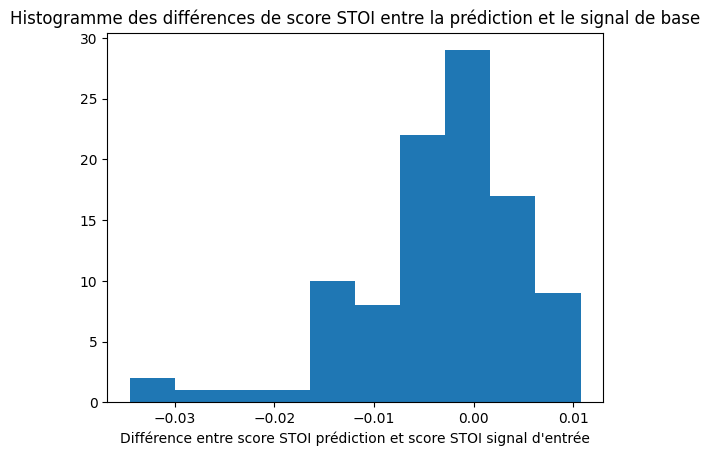

In [28]:
plt.title("Histogramme des différences de score STOI entre la prédiction et le signal de base")
plt.xlabel("Différence entre score STOI prédiction et score STOI signal d'entrée")
plt.hist(np.array(scores[0]["STOI"]) - np.array(scores[1]["STOI"]) )

En considérant le score STOI, le modèle semble rendre l'audio légèrement moins compréhensible.

(array([ 8., 18., 25., 19., 14.,  9.,  2.,  2.,  0.,  3.]),
 array([0.04346704, 0.06865942, 0.0938518 , 0.11904418, 0.14423656,
        0.16942894, 0.19462132, 0.2198137 , 0.24500608, 0.27019846,
        0.29539084]),
 <BarContainer object of 10 artists>)

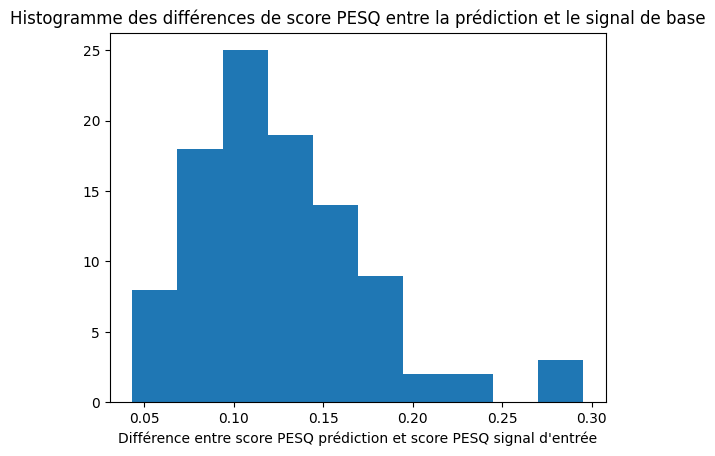

In [29]:
plt.title("Histogramme des différences de score PESQ entre la prédiction et le signal de base")
plt.xlabel("Différence entre score PESQ prédiction et score PESQ signal d'entrée")
plt.hist(np.array(scores[0]["PESQ"]) - np.array(scores[1]["PESQ"]) )

Le score PESQ est amélioré dans tous les cas, mais l'amplitude de l'amélioration reste minime, et pratiquement indetectable à l'oreille.

(array([ 1.,  0.,  2.,  5., 10., 36., 32.,  9.,  2.,  3.]),
 array([-4.20106193, -3.59177689, -2.98249184, -2.37320679, -1.76392175,
        -1.1546367 , -0.54535165,  0.0639334 ,  0.67321844,  1.28250349,
         1.89178854]),
 <BarContainer object of 10 artists>)

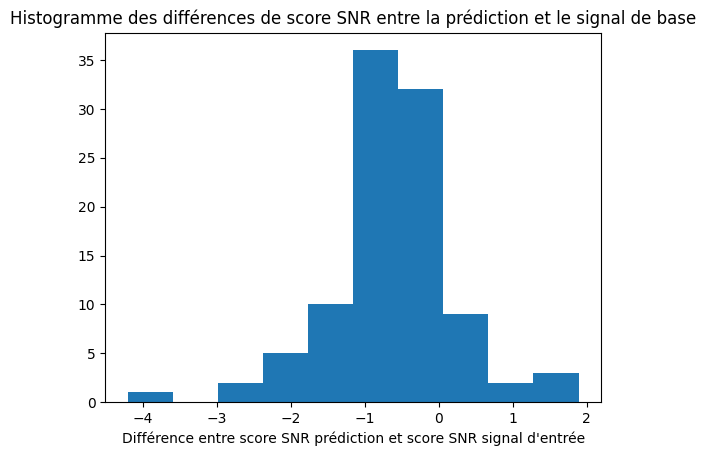

In [30]:
plt.title("Histogramme des différences de score SNR entre la prédiction et le signal de base")
plt.xlabel("Différence entre score SNR prédiction et score SNR signal d'entrée")
plt.hist(np.array(scores[0]["SNR"]) - np.array(scores[1]["SNR"]) )

On aurait pû s'attendre à ce que le modèle rajoute du bruit, mais ce n'est pas le cas.

# Architectures sur la forme d'ondre Wave-U-Net :

Adaptation de l'U-Net pour les signaux audio (signaux 1D) :
- Encodeurs/Decodeurs de convolutions 1D : Réduction/Augmentation progressive de la résolution temporelle (downsampling/upsampling)
- Pas de pooling : Utilise des décimations pour réduire la résolution temporelle (downsampling).
Skip connections :
Relient les caractéristiques de l'encodeur à celles du décodeur pour préserver des informations locales et globales.

In [ ]:
# Wave-U-Net implementation
class DecimateLayer(torch.nn.Module):
    def __init__(self):
        super(DecimateLayer, self).__init__()
    def forward(self, x):
        return x[:, :, ::2]

def center_crop(tensor, target_size):
    """
    Centre crop un tenseur le long de la dimension temporelle.
    Args:
        tensor (torch.Tensor): Tenseur d'entrée de forme [B, C, T].
        target_size (int): Taille cible sur la dimension T.
    Returns:
        torch.Tensor: Tenseur cropped de forme [B, C, target_size].
    """
    _, _, current_size = tensor.shape
    if current_size == target_size:
        return tensor  # Pas besoin de crop si déjà à la bonne taille
    elif current_size < target_size:
        raise ValueError(f"Current size ({current_size}) is smaller than target size ({target_size}).")
    # Calcul des marges à enlever
    crop_start = (current_size - target_size) // 2
    crop_end = crop_start + target_size
    return tensor[:, :, crop_start:crop_end]


class WaveUNet(nn.Module):
    def __init__(self, L, input_channels, output_channels, Fc, fd, fu):
        """
        Inspired by : D. Stoller  et Al., WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018
        Implements the base architecture of the WaveUNet Architecture
        - L : the number of layers (L encoders, L decoders, 1 middle layer)
        - input_channels = 1 une série temporelle
        - output_channels = 1 une série temporelle
        - Fc: Nombre de filtres de base (channels)
        - fd: Taille du noyau pour downsampling
        - fu: Taille du noyau pour upsampling
        """
        super(WaveUNet, self).__init__()
        self.L = L

        # Downsampling (DS) Layers
        self.downsampling_conv = nn.ModuleList()
        for i in range(0, L):
            #in_channels = input_channels if i == 0 else Fc * (2 ** (i - 1))
            #out_channels = Fc * (2 ** i)
            in_channels = 1 if i==0 else Fc*i
            out_channels = Fc*(i+1)
            self.downsampling_conv.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=fd, stride=1, padding=fd//2),
                    nn.LeakyReLU(negative_slope=0.2)
                )
            )
        self.decimate = DecimateLayer()

        # Middle Layer
        self.middle_conv = nn.Conv1d(Fc * L, Fc * (L + 1), kernel_size=fd, stride=1, padding=fd//2)
        self.middle_relu = nn.LeakyReLU(negative_slope=0.2)
        # Pas de decimate pour cette couche

        # Upsampling (US) Layers
        self.interpolate_samples = nn.Upsample(scale_factor=2, mode='linear', align_corners=True) # Upsample linear interpolation

        self.upsampling_conv = nn.ModuleList()
        for i in range(L, 0, -1):
          in_channels = Fc*(i+1) + Fc*i # Nombre de canaux avant concaténation
          out_channels = 1 if i== 0 else Fc*i  # Nombre de canaux après l'upsampling

          self.upsampling_conv.append(
              nn.Sequential(
                  nn.Conv1d(in_channels, out_channels, kernel_size=fu, stride=1, padding=fu//2),
                  nn.LeakyReLU(negative_slope=0.2)
              )
          )

        # Final Layer (output with 1 channel)
        self.final_conv = nn.Conv1d(Fc + 1, 1, kernel_size=1)  # Conv1D(1, 1) for final output

    def forward(self, x):
        downsampled = [x]
        # Downsampling block
        for ds_layer in self.downsampling_conv:
            x = ds_layer(x)
            downsampled.append(x)
            x = self.decimate(x)
        # Middle Layer
        x = self.middle_conv(x)
        x = self.middle_relu(x)

        # Upsampling block
        for i, us_layer in enumerate(self.upsampling_conv):
            to_concat = downsampled[-(i+1)]
            #print()
            #print("Données avant :")
            #print("x Avant:", x.shape)
            #print("c Avant:", to_concat.shape)
            x = self.interpolate_samples(x)  # Upsample
            #x = us_layer(x)
            #print("Données après :")
            #print("x après interpolation", x.shape)
            # cropped high level concatenation
            x = center_crop(x, to_concat.shape[2])
            #print("x après crop:", x.shape)
            #padded_to_concat = F.pad(to_concat, (0, x.shape[2] - to_concat.shape[2]))
            #print("c après padding:", padded_to_concat.shape)
            x = torch.cat([x, to_concat], dim=1)  # Concatenate the previous downsampled features
            #print("[x,c]", x.shape)
            x = us_layer(x)
            #print("[x,c] après convolution", x.shape)
        #print("Fin upsampling:", x.shape)
        # Final layers
        to_concat = downsampled[0]
        x = torch.cat([x, to_concat], dim=1)
        x = self.final_conv(x)
        return x

In [ ]:
#del model_WaveUNet

In [ ]:
model_WaveUNet = WaveUNet(L=4, input_channels=1, output_channels=1, Fc=24, fd=15, fu=5) #Paramètres comme dans l'article
# Test de la consistence des shapes e/s
for batch_signals, batch_labels in dataloader_train:  # Le DataLoader retourne les données par batch
    print("Shape de l'entrée :", batch_signals.shape)
    output = model_WaveUNet(batch_signals) # Forward
    print("Shape de la sortie :", output.shape)  # Vérifier la forme de la sortie
    break  # On sort de la boucle après un batch pour un test rapide

Shape de l'entrée : torch.Size([16, 1, 80000])
Shape de la sortie : torch.Size([16, 1, 80000])


In [ ]:
print(sum([p.numel() for p in model_WaveUNet.parameters()])) # Nombre de paramètres

548186


____
**La toute première architecture testée est exactement celle de l'article : L = 12, FC = 24, loss = mse, sur 50 epochs**

In [ ]:
epochs = 50
train = True
chemin_vers_sauvegarde_model = chemin + "model_backup/model.pt"

In [ ]:
if train:
  logger = train_model(model_WaveUNet, epochs, chemin_vers_sauvegarde_model, loss = 'mse')

Training started...
epoch 50/50 and batch 133
...Done!


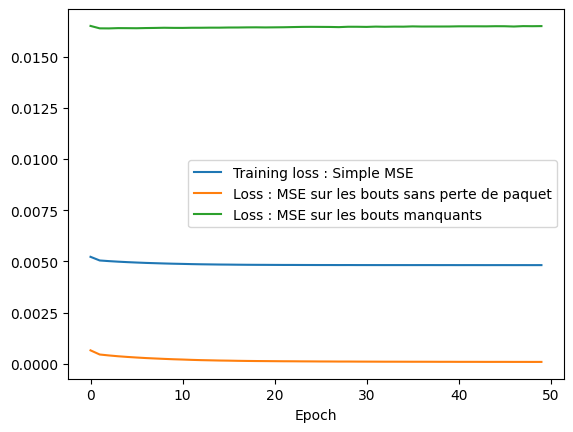

In [ ]:
if train:
  plt.plot(logger.metrics_train['loss_mse'], label='Training loss : Simple MSE')
  plt.plot(logger.metrics_train['loss_masque_sans_perte'], label='Loss : MSE sur les bouts sans perte de paquet')
  plt.plot(logger.metrics_train['loss_masque_avec_perte'], label='Loss : MSE sur les bouts manquants')
  plt.legend()
  plt.xlabel('Epoch')

_____
**Nouvelle architecture : uniquement 4-1-4 couches comme pour le U-Net qui fonctionne**


In [ ]:
epochs = 15
train = True
chemin_vers_sauvegarde_model = chemin + "model_backup/model_mse_L4.pt"

In [ ]:
if train:
  logger = train_model(model_WaveUNet, epochs, chemin_vers_sauvegarde_model, loss='mse')

Training started...
epoch 15/15 and batch 133
...Done!


In [ ]:
chemin_logger = chemin + "model_backup/logger_mse_L4.pt"

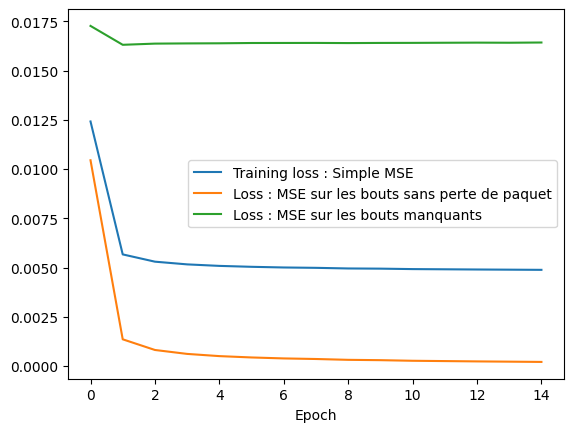

In [ ]:
if train:
  plt.plot(logger.metrics_train['loss_mse'], label='Training loss : Simple MSE')
  plt.plot(logger.metrics_train['loss_masque_sans_perte'], label='Loss : MSE sur les bouts sans perte de paquet')
  plt.plot(logger.metrics_train['loss_masque_avec_perte'], label='Loss : MSE sur les bouts manquants')
  plt.legend()
  plt.xlabel('Epoch')

On observe les mêmes stagnations

Testons la perte L1 comme sur le U-net qui fonctionne

___
**Idem mais avec une L1**

In [ ]:
epochs = 15
train = True
chemin_vers_sauvegarde_model = chemin + "model_backup/model_l1_L4.pt"

In [ ]:
if train:
  logger = train_model(model_WaveUNet, epochs, chemin_vers_sauvegarde_model, loss='l1')

Training started...
epoch 15/15 and batch 133
...Done!


In [ ]:
chemin_logger = chemin + "model_backup/logger_l1_L4.pt"
torch.save(logger, chemin_logger)

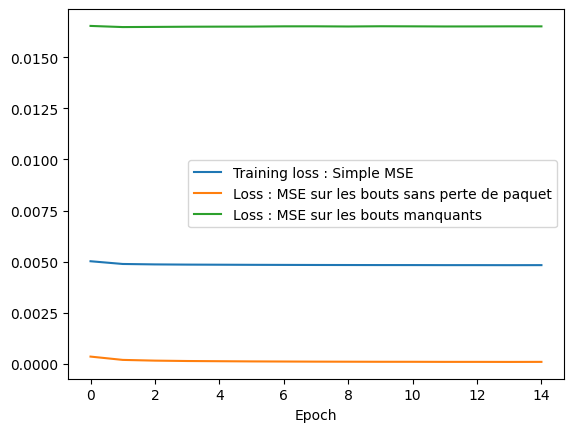

In [ ]:
if train:
  plt.plot(logger.metrics_train['loss_mse'], label='Training loss : Simple MSE')
  plt.plot(logger.metrics_train['loss_masque_sans_perte'], label='Loss : MSE sur les bouts sans perte de paquet')
  plt.plot(logger.metrics_train['loss_masque_avec_perte'], label='Loss : MSE sur les bouts manquants')
  plt.legend()
  plt.xlabel('Epoch')

___
**Test en découpant les signaux trop longs en petits bouts comme pour U-Net**

In [ ]:
epochs = 15
train = True
chemin_vers_sauvegarde_model = chemin + "model_backup/model_petitsbouts.pt"

In [ ]:
if train:
  logger = train_model(model_WaveUNet, epochs, chemin_vers_sauvegarde_model, loss='l1')

Training started...
epoch 15/15 and batch 10590
...Done!


In [ ]:
chemin_logger = chemin + "model_backup/logger_petitsbouts.pt"
torch.save(logger, chemin_logger)

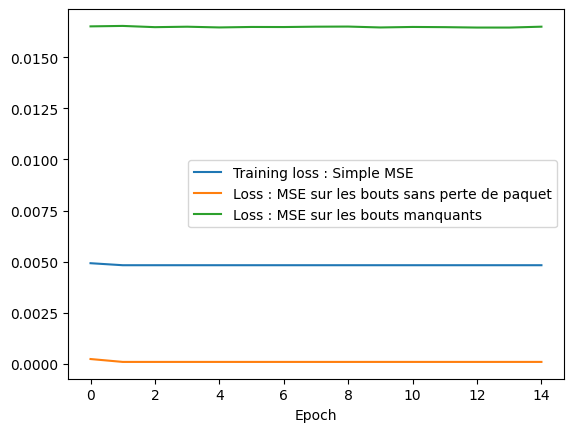

In [ ]:
if train :
  plt.plot(logger.metrics_train['loss_mse'], label='Training loss : Simple MSE')
  plt.plot(logger.metrics_train['loss_masque_sans_perte'], label='Loss : MSE sur les bouts sans perte de paquet')
  plt.plot(logger.metrics_train['loss_masque_avec_perte'], label='Loss : MSE sur les bouts manquants')
  plt.legend()
  plt.xlabel('Epoch')

In [ ]:
epochs = 30
train = True
chemin_vers_sauvegarde_model = chemin + "model_backup/model_sommelossbest.pt"

In [ ]:
if train:
  logger = train_model(model_WaveUNet, epochs, chemin_vers_sauvegarde_model, loss='combination')

Training started...
epoch 30/30 and batch 133
...Done!


In [ ]:
chemin_logger = chemin + "model_backup/logger_sommelossbest.pt"
torch.save(logger, chemin_logger)

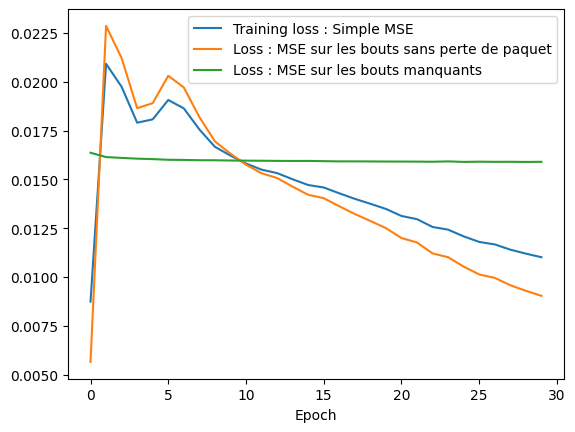

In [ ]:
if train:
  plt.plot(logger.metrics_train['loss_mse'], label='Training loss : Simple MSE')
  plt.plot(logger.metrics_train['loss_masque_sans_perte'], label='Loss : MSE sur les bouts sans perte de paquet')
  plt.plot(logger.metrics_train['loss_masque_avec_perte'], label='Loss : MSE sur les bouts manquants')
  plt.legend()
  plt.xlabel('Epoch')

In [ ]:
#loaded_logger = torch.load(chemin_logger)
#plt.plot(loaded_logger.metrics_train['loss_mse'], label='Training loss : Simple MSE')

<ipython-input-29-6ef85249d69c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_logger = torch.load(chemin_logger)


____
## Test de reconstructions

In [ ]:
# Loader le modèle entrainé
chemin_vers_sauvegarde_model = chemin + "model_backup/model_petitsbouts.pt"

# --- Si on a un GPU :
if torch.cuda.is_available():
    model_WaveUNet = torch.load(chemin_vers_sauvegarde_model)
# --- Si on a un CPU :
else:
    model_WaveUNet = torch.load(chemin_vers_sauvegarde_model, map_location=torch.device('cpu'))

<ipython-input-22-d02be89d4b54>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_WaveUNet = torch.load(chemin_vers_sauvegarde_model, map_location=torch.device('cpu'))


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_WaveUNet.eval()  # Met le modèle en mode évaluation (désactive dropout, etc.)
X_test_reconstruits = []

with torch.no_grad():  # Pas de calcul de gradients
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader_test):
        print(batch_idx)
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) # Envoi au GPU si disponible
        # Prédictions
        batch_y_predicted = model_WaveUNet(batch_x) # Logits de sortie du modèle = probabilité d'appartenance à chaque classe
        # Stocker les reconstructions sur le CPU
        # - libère de l'espace de calcul sur le GPU
        X_test_reconstruits.append(batch_y_predicted.cpu()) # Déplacer sur CPU
        break

# Concatenation des batches
X_test_reconstruits = torch.cat(X_test_reconstruits)
X_test_reconstruits = [signal.detach().numpy() for signal in X_test_reconstruits]

0


In [ ]:
idx = 10
samplerate = 8000
print(len(X_test_reconstruits))


signal_loss, signal_og = dataset_test[idx][0].numpy(), dataset_test[idx][1].numpy()
signal_reconstruit = X_test_reconstruits[idx]

789


In [ ]:
# Signal original
IPython.display.Audio(signal_og, rate=samplerate)

In [ ]:
# Signal avec perte de paquets
IPython.display.Audio(signal_loss, rate=samplerate)

In [ ]:
# Signal reconstruit
IPython.display.Audio(signal_reconstruit, rate=samplerate)

In [ ]:
signal_og = signal_og.squeeze()
signal_loss = signal_loss.squeeze()
signal_reconstruit = signal_reconstruit.squeeze()
print(signal_og.shape)
print(signal_loss.shape)
print(signal_reconstruit.shape)

(80000,)
(80000,)
(80000,)


In [ ]:
pesq_avant = pesq(samplerate, signal_og, signal_loss, 'nb')
pesq_apres = pesq(samplerate, signal_og, signal_reconstruit, 'nb')
print("PESQ avant", pesq_avant)
print("PESQ après", pesq_apres)

PESQ avant 1.2780455350875854
PESQ après 1.2781959772109985


In [ ]:
stoi_avant = stoi(signal_og, signal_loss, samplerate)
stoi_apres = stoi(signal_og, signal_reconstruit, samplerate)
print("STOI avant :", stoi_avant)
print("STOI après :", stoi_apres)

STOI avant : 0.7352669760172525
STOI après : 0.7352169946329399


# Références
1. Kong, Qiuqiang & Cao, Yin & Liu, Haohe & Choi, Keunwoo & Wang, Yuxuan. (2021). Decoupling Magnitude and Phase Estimation with Deep ResUNet for Music Source Separation. 10.48550/arXiv.2109.05418.
2. Daniel Stoller, Sebastian Ewert, Simon Dixon, Wave-U-Net: A Multi-Scale Neural Network for End-to-End Audio Source Separation, 2018
3. A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017
